# Carga de Drive y todas las librerias necesarias

CELDA 1 - Montar Google Drive


In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


CELDA 2 - Importar todo lo necesario

In [106]:
#IMPORTS
import tensorflow as tf
import keras                      
import numpy as np
import cv2   
import csv
import os
import math
import random
import pickle
import tensorflow.keras.layers
import tensorflow.keras.models
%matplotlib inline
from glob import glob
from keras import optimizers
from keras import layers
from keras import models
from keras.models import Model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose,concatenate
from keras.layers import BatchNormalization
from keras.models import Model,Sequential
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn import tree
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import zero_one_loss
from sklearn.metrics import recall_score
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from PIL import Image

CELDA 3 - Definir constantes

In [107]:
#CONSTANTES

IMA_SIZE = 128

NUM_TRAIN_FILES = 20
NUM_TEST_FILES = 2


# Presentación de datos totales detallados

CELDA 4 - Definir paths de entrenamiento y de prueba

In [108]:
train_path = '/content/drive/My Drive/Colab Notebooks/chest_xray/train'
train_sanas_path = '/content/drive/My Drive/Colab Notebooks/chest_xray/train/NORMAL'
train_enfermas_path = '/content/drive/My Drive/Colab Notebooks/chest_xray/train/PNEUMONIA'

test_path = '/content/drive/My Drive/Colab Notebooks/chest_xray/test'
test_sanas_path = '/content/drive/My Drive/Colab Notebooks/chest_xray/test/NORMAL'
test_enfermas_path = '/content/drive/My Drive/Colab Notebooks/chest_xray/test/PNEUMONIA'

val_path = '/content/drive/My Drive/Colab Notebooks/chest_xray/val'

CELDA 5 - Presentación de los datos detallados

In [109]:
train_data_dir = train_path  
train_data_sanas_dir = train_sanas_path
train_data_enfermas_dir = train_enfermas_path

validation_data_dir = val_path

test_data_dir = test_path 
test_data_sanas_dir = test_sanas_path 
test_data_enfermas_dir = test_enfermas_path 

target_names = [item for item in os.listdir(train_data_dir) if os.path.isdir(os.path.join(train_data_dir, item))]

nb_train_samples = sum([len(files) for _, _, files in os.walk(train_data_dir)])  
nb_train_sanas_samples = sum([len(files) for _, _, files in os.walk(train_data_sanas_dir)])  
nb_train_enfermas_samples = sum([len(files) for _, _, files in os.walk(train_data_enfermas_dir)])  

nb_validation_samples = sum([len(files) for _, _, files in os.walk(validation_data_dir)])

nb_test_samples = sum([len(files) for _, _, files in os.walk(test_data_dir)])
nb_test_sanas_samples = sum([len(files) for _, _, files in os.walk(test_data_sanas_dir)])
nb_test_enfermas_samples = sum([len(files) for _, _, files in os.walk(test_data_enfermas_dir)])

total_nb_samples = nb_train_samples + nb_validation_samples + nb_test_samples

epochs = 100
batch_size = 32

nb_classes = len(target_names)      # number of output classes

print( '\n - Número de clases: ', nb_classes, '\n - Nombre de las clases: ', target_names, '\n')
print(' - Número de imágenes sanas de entrenamiento: ', nb_train_sanas_samples,
      '\n - Número de imágenes enfermas de entrenamiento: ', nb_train_enfermas_samples,
      '\n - Número de imágenes totales de entrenamiento: ', nb_train_samples, '\n'
      '\n - Número de imágenes sanas de prueba: ', nb_test_sanas_samples,
      '\n - Número de imágenes enfermas de prueba: ', nb_test_enfermas_samples, 
      '\n - Número de imágenes totales de prueba: ', nb_test_samples,'\n'
      '\n - Número de ejemplos de validación: ', nb_validation_samples,
      '\n   --------------------------------\n - Número de ejemplos totales: ', total_nb_samples,
      '\n\n - Número de epochs: ', epochs, '\n - Tamaño del batch: ', batch_size)


 - Número de clases:  2 
 - Nombre de las clases:  ['NORMAL', 'PNEUMONIA'] 

 - Número de imágenes sanas de entrenamiento:  1364 
 - Número de imágenes enfermas de entrenamiento:  3986 
 - Número de imágenes totales de entrenamiento:  5351 

 - Número de imágenes sanas de prueba:  234 
 - Número de imágenes enfermas de prueba:  390 
 - Número de imágenes totales de prueba:  625 

 - Número de ejemplos de validación:  19 
   --------------------------------
 - Número de ejemplos totales:  5995 

 - Número de epochs:  100 
 - Tamaño del batch:  32


# Carga/Presentación de imágenes y etiquetas para entrenamiento

CELDA 6 - Carga de imágenes y etiquetas sanas para entrenamiento

In [110]:
train_sanas_list_path = shuffle(glob('/content/drive/My Drive/Colab Notebooks/chest_xray/train/NORMAL/*.jpeg'))
train_sanas_files_path = '/content/drive/My Drive/Colab Notebooks/TFG/' + 'train_normal_image_file_{}.npy'
label_sanas_files_path = '/content/drive/My Drive/Colab Notebooks/TFG/' + 'train_normal_image_label_file_{}.npy'

max_images = math.floor(len(train_sanas_list_path) / NUM_TRAIN_FILES)
max_labels = max_images
print('Número de imágenes sanas para entrenamiento ->', len(train_sanas_list_path), ' de las que utilizaremos ', max_images * NUM_TRAIN_FILES)
print('Número de archivos de imágenes sanas para entrenamiento ->', NUM_TRAIN_FILES)
print('Número de imágenes sanas por archivo ->', max_images,'\n')

print('Número de etiquetas de imágenes sanas para entrenamiento ->', len(train_sanas_list_path),' de las que utilizaremos ', max_images * NUM_TRAIN_FILES)
print('Número de archivos de etiquetas de imágenes sanas para entrenamiento ->', NUM_TRAIN_FILES)
print('Número de etiquetas por archivo ->', max_images)

index = 0
for train_file_index in range(NUM_TRAIN_FILES):

  train_images = []
  train_label = []
  i = 0
  for i in range(max_images - 1):
    image_path = train_sanas_list_path[index]
    #print(image_path)
    if image_path.endswith(".jpeg"):
      if "NORMAL" in image_path:
        image = cv2.imread(image_path)
        image = cv2.resize(image,(IMA_SIZE,IMA_SIZE))
        train_images.append(image)
        label = 0
        label = str(label)
        #print(label)
        train_label.append(label)
        #print("Normal")

    index = index + 1

  train_sanas_images = np.array(train_images)
  train_sanas_labels = np.array(train_label)
  #print(image_path)
  print('\n Número de archivo ', train_file_index)
  print('Creado archivo imágenes sanas con path -> ', train_sanas_files_path.format(train_file_index))
  print('Creado archivo etiquetas de imágenes sanas con path -> ', label_sanas_files_path.format(train_file_index))

  np.save(train_sanas_files_path.format(train_file_index), train_sanas_images)
  np.save(label_sanas_files_path.format(train_file_index), train_sanas_labels)

#comprobacion = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_sana_image_file_0.npy')
#print('\n',len(comprobacion))
print('\n','Archivos de imágenes sanas de entrenamiento creados con éxito')
print('\n','Archivos de etiquetas sanas de entrenamiento creados con éxito')

Número de imágenes sanas para entrenamiento -> 1363  de las que utilizaremos  1360
Número de archivos de imágenes sanas para entrenamiento -> 20
Número de imágenes sanas por archivo -> 68 

Número de etiquetas de imágenes sanas para entrenamiento -> 1363  de las que utilizaremos  1360
Número de archivos de etiquetas de imágenes sanas para entrenamiento -> 20
Número de etiquetas por archivo -> 68


KeyboardInterrupt: ignored

CELDA 7 - Presentación de imagen sana aleatoria y etiqueta para entrenamiento

In [111]:
a = random.randint(0, 19)
b =  random.randint(0, 67)

imagen_1 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/' + 'train_normal_image_file_'+ str(a)+'.npy')
label_1 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/' + 'train_normal_image_label_file_'+str(a)+'.npy')



print('Esto es un ejemplo de una imagen sana de entrenamiento con path -> /content/drive/My Drive/Colab Notebooks/TFG/' + 'train_normal_image_file_' + str(a) +'.npy \n'
'Número de imagen',b , '\n', imagen_1[b], '\n')
print('Y esto es un ejemplo de etiqueta de la imagen', b,'para ver que sólo se han cargado las imágenes de pulmones sanos -> \n', label_1[b])

Esto es un ejemplo de una imagen sana de entrenamiento con path -> /content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_file_18.npy 
Número de imagen 0 
 [[[ 17  17  17]
  [ 19  19  19]
  [ 19  19  19]
  ...
  [103 103 103]
  [100 100 100]
  [ 99  99  99]]

 [[ 29  29  29]
  [ 33  33  33]
  [ 36  36  36]
  ...
  [ 99  99  99]
  [ 99  99  99]
  [ 93  93  93]]

 [[ 39  39  39]
  [ 41  41  41]
  [ 45  45  45]
  ...
  [102 102 102]
  [100 100 100]
  [ 89  89  89]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]] 

Y esto es un ejemplo de etiqueta de la imagen 0 para ver que sólo se han cargado las imágenes de pulmones sanos -> 
 0


CELDA 8 - Carga de imágenes y etiquetas enfermas para entrenamiento

In [112]:
train_enfermas_list_path = shuffle(glob('/content/drive/My Drive/Colab Notebooks/chest_xray/train/PNEUMONIA/*.jpeg'))
train_enfermas_files_path = '/content/drive/My Drive/Colab Notebooks/TFG/' + 'train_enferma_image_file_{}.npy'
label_enfermas_files_path = '/content/drive/My Drive/Colab Notebooks/TFG/' + 'train_enferma_image_label_file_{}.npy'



max_images = 68 #math.floor(len(train_enfermas_list_path) / NUM_TRAIN_FILES)
max_labels = max_images
print('Número de imágenes enfermas para entrenamiento', len(train_enfermas_list_path),', pero para igualar con el número de imágenes '
'sanas, se utilizarán', max_images * NUM_TRAIN_FILES)
print('Número de archivos de imágenes enfermas para entrenamiento', NUM_TRAIN_FILES)
print('Número de imágenes enfermas por archivo', max_images,'\n')

print('Número de etiquetas de imágenes enfermas para entrenamiento', len(train_enfermas_list_path),', pero para igualar con el número de imágenes '
'sanas, se utilizarán', max_images * NUM_TRAIN_FILES)
print('Número de archivos de etiquetas de imágenes enfermas de entrenamiento', NUM_TRAIN_FILES)
print('Número de etiquetas por archivo', max_images)

index = 0
for train_file_index in range(NUM_TRAIN_FILES):

 train_images = []
 train_label = []
 for i in range(max_images):
   image_path = train_enfermas_list_path[index]
   #print(image_path)
   if image_path.endswith(".jpeg"):
     if "PNEUMONIA" in image_path:
       image = cv2.imread(image_path)
       image = cv2.resize(image,(IMA_SIZE,IMA_SIZE))
       train_images.append(image)
       label = 1
       label = str(label)
       #print(label)
       train_label.append(label)
       #print("Normal")

   index = index + 1

 train_enfermas_images = np.array(train_images)
 train_enfermas_labels = np.array(train_label)
 #print(image_path)
 print('\n Número de archivo ', train_file_index)
 print('Creado archivo imagenes con path -> ', train_enfermas_files_path.format(train_file_index))
 print('Creado archivo etiquetas con path -> ', label_enfermas_files_path.format(train_file_index))

 np.save(train_enfermas_files_path.format(train_file_index), train_enfermas_images)
 np.save(label_enfermas_files_path.format(train_file_index), train_enfermas_labels)

#comprobacion = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_file_0.npy')
#print('\n',len(comprobacion))
print('\n','Archivos de imagenes enfermas de entrenamiento creados con exito')
print('\n','Archivos de etiquetas enfermas de entrenamiento creados con exito')

Número de imágenes enfermas para entrenamiento 3985 , pero para igualar con el número de imágenes sanas, se utilizarán 1360
Número de archivos de imágenes enfermas para entrenamiento 20
Número de imágenes enfermas por archivo 68 

Número de etiquetas de imágenes enfermas para entrenamiento 3985 , pero para igualar con el número de imágenes sanas, se utilizarán 1360
Número de archivos de etiquetas de imágenes enfermas de entrenamiento 20
Número de etiquetas por archivo 68


KeyboardInterrupt: ignored

CELDA 9 - Presentación de imagen enferma aleatoria y etiqueta para entrenamiento

In [114]:
a = random.randint(0, 19)
b =  random.randint(0, 67)

imagen_1 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/' + 'train_enferma_image_file_'+ str(a)+'.npy')
label_1 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/' + 'train_enferma_image_label_file_'+str(a)+'.npy')

print('Esto es un ejemplo de una imagen enferma de entrenamiento con path -> /content/drive/My Drive/Colab Notebooks/TFG/' + 'train_enferma_image_file_' + str(a)+ '.npy \n'
'Número de imagen',b , '\n', imagen_1[b], '\n')
print('Y esto es un ejemplo de etiqueta de la imagen',b,'para ver que sólo se han cargado las imágenes de pulmones enfermos -> \n', label_1[b])

Esto es un ejemplo de una imagen enferma de entrenamiento con path -> /content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_file_10.npy 
Número de imagen 60 
 [[[ 20  20  20]
  [ 24  24  24]
  [ 31  31  31]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[ 17  17  17]
  [ 23  23  23]
  [ 28  28  28]
  ...
  [  6   6   6]
  [  1   1   1]
  [  0   0   0]]

 [[ 15  15  15]
  [ 22  22  22]
  [ 27  27  27]
  ...
  [  1   1   1]
  [254 254 254]
  [  0   0   0]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [157 157 157]
  [  2   2   2]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  5   5   5]
  [  1   1   1]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]] 

Y esto es un ejemplo de etiqueta de la imagen 60 para ver que sólo se han cargado las imágenes de pulmones enfermos -> 
 1


# Carga/Presentación de imágenes y etiquetas para pruebas

CELDA 10 - Carga de imágenes y etiquetas sanas para pruebas

In [118]:
 test_sanas_list_path = shuffle(glob('/content/drive/My Drive/Colab Notebooks/chest_xray/test/NORMAL/*.jpeg'))
 test_sanas_files_path = '/content/drive/My Drive/Colab Notebooks/TFG/' + 'test_normal_image_file_{}.npy'
 label_sanas_files_path = '/content/drive/My Drive/Colab Notebooks/TFG/' + 'test_normal_image_label_file_{}.npy'


 max_images = math.floor(len(test_sanas_list_path) / NUM_TEST_FILES)
 print('Número de imágenes sanas totales para pruebas', len(test_sanas_list_path))
 print('Número de archivos de imágenes sanas para pruebas', NUM_TEST_FILES)
 print('Número de imágenes por archivo', max_images,'\n')

 print('Número de etiquetas de imágenes sanas para pruebas', len(test_sanas_list_path))
 print('Número de archivos de etiquetas de imágenes sanas de prueba', NUM_TEST_FILES)
 print('Número de etiquetas por archivo', max_images)

 index = 0
 for test_file_index in range(NUM_TEST_FILES):

  test_images = []
  test_label = []

  for i in range(max_images):
    image_path = test_sanas_list_path[index]
    #print(image_path)
    if image_path.endswith(".jpeg"):
      if "NORMAL" in image_path:
        image = cv2.imread(image_path)
        image = cv2.resize(image,(IMA_SIZE,IMA_SIZE))
        test_images.append(image)
        label = 0
        label = str(label)
        #print(label)
        test_label.append(label)
        #print("NORMAL")

    index = index + 1

  test_images = np.array(test_images)
  test_label = np.array(test_label)
  #print(image_path)
  print('\n Número de archivo', test_file_index)
  print('Creado archivo imagenes con path -> ', test_sanas_files_path.format(test_file_index))
  print('Creado archivo etiquetas con path -> ', label_sanas_files_path.format(test_file_index))
  np.save(test_sanas_files_path.format(test_file_index), test_images)
  np.save(label_sanas_files_path.format(test_file_index), test_label)

#comprobacion = np.load('/content/drive/My Drive/Colab Notebooks/TFG/test_normal_image_file_0.npy')
#print('\n',len(comprobacion))
print('\n','Archivos de imágenes sanas de prueba creados con éxito')
print('\n','Archivos de etiquetas de imágenes sanas de prueba creados con éxito')

Número de imágenes sanas totales para pruebas 234
Número de archivos de imágenes sanas para pruebas 2
Número de imágenes por archivo 117 

Número de etiquetas de imágenes sanas para pruebas 234
Número de archivos de etiquetas de imágenes sanas de prueba 2
Número de etiquetas por archivo 117

 Número de archivo 0
Creado archivo imagenes con path ->  /content/drive/My Drive/Colab Notebooks/TFG/test_normal_image_file_0.npy
Creado archivo etiquetas con path ->  /content/drive/My Drive/Colab Notebooks/TFG/test_normal_image_label_file_0.npy

 Número de archivo 1
Creado archivo imagenes con path ->  /content/drive/My Drive/Colab Notebooks/TFG/test_normal_image_file_1.npy
Creado archivo etiquetas con path ->  /content/drive/My Drive/Colab Notebooks/TFG/test_normal_image_label_file_1.npy

 Archivos de imágenes sanas de prueba creados con éxito

 Archivos de etiquetas de imágenes sanas de prueba creados con éxito


CELDA 11 - Presentación de imagen sana aleatoria y etiqueta para pruebas

In [119]:
a = random.randint(0, 1)
b =  random.randint(0, 116)

imagen_1 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/' + 'test_normal_image_file_'+ str(a)+'.npy')
label_1 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/' + 'test_normal_image_label_file_'+str(a)+'.npy')

print('Esto es un ejemplo de una imagen sana de prueba con path -> /content/drive/My Drive/Colab Notebooks/TFG/' + 'test_normal_image_file_' + str(a) +'.npy \n'
'Número de imagen',b , '\n', imagen_1[b], '\n')
print('Y esto es un ejemplo de etiqueta de la imagen',b,'para ver que sólo se han cargado las imágenes de pulmones sanos -> \n', label_1[b])

Esto es un ejemplo de una imagen sana de prueba con path -> /content/drive/My Drive/Colab Notebooks/TFG/test_normal_image_file_0.npy 
Número de imagen 35 
 [[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [5 5 5]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [1 1 1]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [1 1 1]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]] 

Y esto es un ejemplo de etiqueta de la imagen 35 para ver que sólo se han cargado las imágenes de pulmones sanos -> 
 0


CELDA 12 - Carga de imágenes y etiquetas enfermas para pruebas

In [120]:
test_enfermas_list_path = shuffle(glob('/content/drive/My Drive/Colab Notebooks/chest_xray/test/PNEUMONIA/*.jpeg'))
test_enfermas_files_path = '/content/drive/My Drive/Colab Notebooks/TFG/' + 'test_enferma_image_file_{}.npy'
label_enfermas_files_path = '/content/drive/My Drive/Colab Notebooks/TFG/' + 'test_enferma_image_label_file_{}.npy'


max_images = 117
print('Número de imágenes enfermas totales para pruebas', len(test_enfermas_list_path),' de las que utilizaremos', max_images * NUM_TEST_FILES)
print('Número de archivos de imágenes enfermas para pruebas', NUM_TEST_FILES)
print('Número de imágenes por archivo', max_images,'\n')

print('Número de etiquetas de imágenes enfermas para pruebas', len(test_enfermas_list_path),' de las que utilizaremos', max_images * NUM_TEST_FILES)
print('Número de archivos de etiquetas de imágenes enfermas de prueba', NUM_TEST_FILES)
print('Número de etiquetas por archivo', max_images)

index = 0
for test_file_index in range(NUM_TEST_FILES):

 test_images = []
 test_label = []

 for i in range(max_images):
   image_path = test_enfermas_list_path[index]
   #print(image_path)
   if image_path.endswith(".jpeg"):
     if "PNEUMONIA" in image_path:
       image = cv2.imread(image_path)
       image = cv2.resize(image,(IMA_SIZE,IMA_SIZE))
       test_images.append(image)
       label = 1
       label = str(label)
       #print(label)
       test_label.append(label)
       #print("PNEUMONIA")
   index = index + 1

 test_images = np.array(test_images)
 test_label = np.array(test_label)
 #print(image_path)
 print('\n Número de archivo', test_file_index)
 print('Creado archivo imagenes con path -> ', test_enfermas_files_path.format(test_file_index))
 print('Creado archivo etiquetas con path -> ', label_enfermas_files_path.format(test_file_index))
 np.save(test_enfermas_files_path.format(test_file_index), test_images)
 np.save(label_enfermas_files_path.format(test_file_index), test_label)

#comprobacion = np.load('/content/drive/My Drive/Colab Notebooks/TFG/test_enferma_image_file_0.npy')
#print('\n',len(comprobacion))
print('\n','Archivos de imagenes enfermas de prueba creados con exito')
print('\n','Archivos de etiquetas de imágenes enfermas de prueba creados con exito')

Número de imágenes enfermas totales para pruebas 390  de las que utilizaremos 234
Número de archivos de imágenes enfermas para pruebas 2
Número de imágenes por archivo 117 

Número de etiquetas de imágenes enfermas para pruebas 390  de las que utilizaremos 234
Número de archivos de etiquetas de imágenes enfermas de prueba 2
Número de etiquetas por archivo 117

 Número de archivo 0
Creado archivo imagenes con path ->  /content/drive/My Drive/Colab Notebooks/TFG/test_enferma_image_file_0.npy
Creado archivo etiquetas con path ->  /content/drive/My Drive/Colab Notebooks/TFG/test_enferma_image_label_file_0.npy

 Número de archivo 1
Creado archivo imagenes con path ->  /content/drive/My Drive/Colab Notebooks/TFG/test_enferma_image_file_1.npy
Creado archivo etiquetas con path ->  /content/drive/My Drive/Colab Notebooks/TFG/test_enferma_image_label_file_1.npy

 Archivos de imagenes enfermas de prueba creados con exito

 Archivos de etiquetas de imágenes enfermas de prueba creados con exito


CELDA 13 - Presentación de imagen enferma aletatoria y etiqueta para prueba

In [121]:
a = random.randint(0, 1)
b =  random.randint(0, 116)

imagen_1 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/' + 'test_enferma_image_file_'+ str(a)+'.npy')
label_1 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/' + 'test_enferma_image_label_file_'+str(a)+'.npy')

print('Esto es un ejemplo de una imagen enferma de prueba con path -> /content/drive/My Drive/Colab Notebooks/TFG/' + 'test_enferma_image_file_' + str(a) + '.npy \n'
'Número de imagen',b , '\n', imagen_1[b], '\n')
print('Y esto es un ejemplo de etiqueta de la iamgen',b,'para ver que sólo se han cargado las imágenes de pulmones enfermos -> \n', label_1[b])

Esto es un ejemplo de una imagen enferma de prueba con path -> /content/drive/My Drive/Colab Notebooks/TFG/test_enferma_image_file_1.npy 
Número de imagen 0 
 [[[34 34 34]
  [33 33 33]
  [34 34 34]
  ...
  [39 39 39]
  [39 39 39]
  [43 43 43]]

 [[31 31 31]
  [36 36 36]
  [34 34 34]
  ...
  [45 45 45]
  [36 36 36]
  [45 45 45]]

 [[35 35 35]
  [36 36 36]
  [37 37 37]
  ...
  [60 60 60]
  [67 67 67]
  [75 75 75]]

 ...

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]] 

Y esto es un ejemplo de etiqueta de la iamgen 0 para ver que sólo se han cargado las imágenes de pulmones enfermos -> 
 1


# Definición/Carga del autogenerador

CELDA 14 - Difinición del generador propio

In [122]:

def my_generator(matrix_path,batch_size=45, batch_per_file=6, shuffle_data=False):
    files_path_list = glob(matrix_path)
    #print(files_path_list)
    file_path = files_path_list[0]
    #print(file_path)

    #len_list = len(files_path_list)
    batch_file_count = 0
    np.random.shuffle(files_path_list)
    #x = np.random.randint(0,len_list)
    #print(x)
    #print(files_path_list)
    file_path = files_path_list[0]
    #print(file_path)

    my_file = np.load(file_path)

    while True: # El generador no termina
        random_indexes = np.random.randint(0, my_file.shape[0], size= batch_size)
        batch = my_file[random_indexes]

        if batch_file_count == batch_per_file:

          #y = np.random.randint(0,len_list)
          #print(y)
          np.random.shuffle(files_path_list)

          file_path = files_path_list[0]

          #print(file_path)
          my_file = np.load(file_path)

          batch_file_count = 0

        batch_file_count = batch_file_count + 1 

        
        yield batch


CELDA 15 - Definición del prepocesamiento

In [123]:
def preprocess(batch):

  batch = batch / 255.
  
  return batch

CELDA 16 - Definición del postprocesamiento (No utilizado)

In [124]:
def postprocess(batch):

  batch = batch * 255.

  return batch

CELDA 17 - Definición del generador propio arreglado




In [125]:
def fixed_generator(generator):
    for batch in generator:
        normalized_batch = preprocess(batch)
        yield (normalized_batch, normalized_batch)

CELDA 18 - Crear generador para las imágenes sanas de entrenamiento

In [126]:
train_sanas_generator = fixed_generator(my_generator('/content/drive/My Drive/Colab Notebooks/TFG/' + 'train_normal_image_file_*.npy'))

validation_sanas_generator = fixed_generator(my_generator('/content/drive/My Drive/Colab Notebooks/TFG/' + 'test_sanas_image_file_*.npy'))

CELDA 19 - Crear generador para las imágenes enfermas de entrenamiento

In [127]:
train_enfermas_generator = fixed_generator(my_generator('/content/drive/My Drive/Colab Notebooks/TFG/' + 'train_enferma_image_file_*.npy'))

validation_enfermas_generator = fixed_generator(my_generator('/content/drive/My Drive/Colab Notebooks/TFG/' + 'test_enferma_image_file_*.npy'))

# Definición del Encoder, Decoder y Autoencoder SANAS

CELDA 20 - Definición del modelo encoder para imágenes sanas

In [ ]:
#ENCODER SANAS
#'''
input = Input(shape=(128,128,3))

x = Conv2D(128, (3, 3), activation='relu', padding='same')(input)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(x)
x = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(x)
x = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(x)

x = Conv2D(16, (3, 3), activation='sigmoid', padding='same')(x)
x = Conv2D(16, (3, 3), activation='sigmoid', padding='same')(x)
x = Conv2D(8, (3, 3), activation='sigmoid', padding='same')(x)

#encoded = x
encoded = MaxPooling2D((2, 2), padding='same')(x)

encoder_sanas = Model(input, encoded, name="encoder_model_sanas")

encoder_sanas.summary() 
#'''

Model: "encoder_model_sanas"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                               

In [ ]:
#imput = Input(shape=(128, 128, 3))

#x = Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu')(x)
#x = Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu')(x)
#x = Flatten()(x),
#Dense(latent_dim + latent_dim)


CELDA 21 - Definición del modelo decoder para imágenes sanas

In [ ]:
#DECODER SANAS
decoder_input = Input(shape=(16,16,8))

x = UpSampling2D((2, 2))(decoder_input)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

#decoded = x
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

decoder_sanas = Model(decoder_input, decoded, name="decoder_model_sanas")

decoder_sanas.summary()

Model: "decoder_model_sanas"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 16, 8)]       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 32, 32, 8)        0         
 )                                                               
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 16)        1168      
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 16)        2320      
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        9248      
                                               

CELDA 22 - Definición del modelo autoencoder para imágenes sanas

In [ ]:
#AUTOENCODER SANAS
auto_input = Input(shape=(128,128,3))

auto_encoder_out = encoder_sanas(auto_input)
auto_decoder_out = decoder_sanas(auto_encoder_out)

autoencoder_sanas = Model(auto_input, auto_decoder_out, name="autoencoder_model_sanas")
autoencoder_sanas.compile(optimizer='adamax', loss='mse', metrics=['acc'])
autoencoder_sanas.summary()

Model: "autoencoder_model_sanas"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 encoder_model_sanas (Functi  (None, 16, 16, 8)        343880    
 onal)                                                           
                                                                 
 decoder_model_sanas (Functi  (None, 128, 128, 3)      491459    
 onal)                                                           
                                                                 
Total params: 835,339
Trainable params: 835,339
Non-trainable params: 0
_________________________________________________________________


# Definición del Encoder, Decoder y Autoencoder ENFERMAS

CELDA 23 - Definición del modelo encoder para imágenes enfermas

In [ ]:
#ENCODER ENFERMAS
input = Input(shape=(128,128,3))

x = Conv2D(128, (3, 3), activation='relu', padding='same')(input)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(x)
x = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(x)
x = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(x)

x = Conv2D(16, (3, 3), activation='sigmoid', padding='same')(x)
x = Conv2D(16, (3, 3), activation='sigmoid', padding='same')(x)
x = Conv2D(8, (3, 3), activation='sigmoid', padding='same')(x)

#encoded = x
encoded = MaxPooling2D((2, 2), padding='same')(x)


encoder_enfermas = Model(input, encoded, name="encoder_model_enfermas")

encoder_enfermas.summary()

Model: "encoder_model_enfermas"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_23 (Conv2D)          (None, 128, 128, 128)     3584      
                                                                 
 conv2d_24 (Conv2D)          (None, 128, 128, 128)     147584    
                                                                 
 conv2d_25 (Conv2D)          (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_26 (Conv2D)          (None, 64, 64, 64)        73792     
                                            

CELDA 24 - Definición del modelo decoder para imágenes enfermas

In [ ]:
#DECODER ENFERMAS
decoder_input = Input(shape=(16,16,8))

x = UpSampling2D((2, 2))(decoder_input)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

#decoded = x
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

decoder_enfermas = Model(decoder_input, decoded, name="decoder_model_enfermas")

decoder_enfermas.summary()

Model: "decoder_model_enfermas"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 16, 16, 8)]       0         
                                                                 
 up_sampling2d_3 (UpSampling  (None, 32, 32, 8)        0         
 2D)                                                             
                                                                 
 conv2d_35 (Conv2D)          (None, 32, 32, 16)        1168      
                                                                 
 conv2d_36 (Conv2D)          (None, 32, 32, 16)        2320      
                                                                 
 conv2d_37 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 conv2d_38 (Conv2D)          (None, 32, 32, 32)        9248      
                                            

CELDA 25 - Definición del modelo autoencoder para imágenes enfermas

In [ ]:
# AUTOENCODER ENFERMAS
auto_input = Input(shape=(128,128,3))

auto_encoder_out = encoder_enfermas(auto_input)
auto_decoder_out = decoder_enfermas(auto_encoder_out)

autoencoder_enfermas = Model(auto_input, auto_decoder_out, name="autoencoder_model_enfermas")
autoencoder_enfermas.compile(optimizer='adamax', loss='mse', metrics=['acc'])
autoencoder_enfermas.summary()

Model: "autoencoder_model_enfermas"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 encoder_model_enfermas (Fun  (None, 16, 16, 8)        491464    
 ctional)                                                        
                                                                 
 decoder_model_enfermas (Fun  (None, 128, 128, 3)      491459    
 ctional)                                                        
                                                                 
Total params: 982,923
Trainable params: 982,923
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=sgd)
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 conv2d_48 (Conv2D)          (None, 124, 124, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 62, 62, 32)        0         
                                                                 
 conv2d_49 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 conv2d_50 (Conv2D)          (None, 58, 58, 32)        9248      
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


# Muestra de imágenes 

CELDA 26 - Muestra de imagen enferma de ejemplo

Representación de imagen enferma de entrenamiento. Lote -> 17, Imagen ->16
Forma de la imagen ->  (128, 128, 3)
Etiqueta de la imagen ->  1


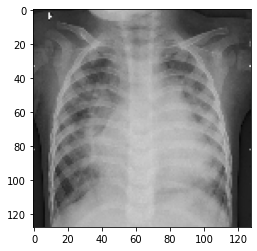

In [128]:
d = random.randint(0,19)
c = random.randint(0,67)

images_2 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_file_'+str(d)+'.npy') 
label_2 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_label_file_'+str(d)+'.npy')

images_2 = np.array(images_2)
label_2 = np.array(label_2)

image_e = images_2[c]
label = label_2[c]

imgplot = plt.imshow(image_e)


print('Representación de imagen enferma de entrenamiento. Lote -> '+str(d)+', Imagen ->'+str(c))
print('Forma de la imagen -> ', image_e.shape) 
print('Etiqueta de la imagen -> ', label)
plt.show()

CELDA 27 - Muestra de imagen sana de ejemplo

Representación de imagen sana de entrenamiento. Lote -> 12, Imagen ->2
Forma de la imagen ->  (128, 128, 3)
Etiqueta de la imagen -> 0


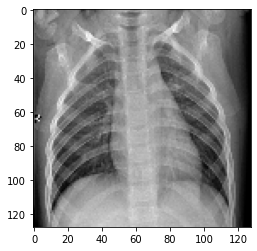

In [169]:
a = random.randint(0,19)
b = random.randint(0,67)

images_1 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_file_'+str(a)+'.npy') 
label_1 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_label_file_'+str(a)+'.npy')

images_1 = np.array(images_1)
label_1 = np.array(label_1)

image = images_1[b]
label = label_1[b]

imgplot = plt.imshow(image)


print('Representación de imagen sana de entrenamiento. Lote -> '+str(a)+', Imagen ->'+str(b))
print('Forma de la imagen -> ', image.shape) 
print('Etiqueta de la imagen ->', label)
plt.show()


CELDA 28 - Muestra de la reconstrucción de una imagen sana con modelo de sanas sin entrenar

In [130]:
no_predicted_images = autoencoder_sanas.predict(images_1)
no_predicted = no_predicted_images[b]
no_predicted_label = label_1[b]
imgplot = plt.imshow(no_predicted)


print('Representación de la reconstrucción del autoencoder aun sin entrenar de la imagen sana de entrenamiento anteriormente mostrada. \n Lote -> '+str(a)+', Imagen -> '+str(b))
print('Forma de la imagen -> ', no_predicted.shape) 
print('Etiqueta de la imagen -> ', no_predicted_label)
plt.show()

NameError: ignored

# ** Entrenamiento del modelo

NO EJECUTAR SIEMPRE. Este grupo de celdas tan solo debe ejecutarse cuando se quiera entrenar un nuevo modelo previamente definido en los apartados anteriores. Los modelos propuestos (1,2,3,4,5) se han guardado en el repositorio y ya están plenamente entrenados. Su carga se realiza en celdas posteriores.

CELDA 29 - Entrenamiento del modelo autoencoder para imágenes sanas

In [ ]:
history_sanas = autoencoder_sanas.fit_generator(train_sanas_generator,
                epochs=100,
                steps_per_epoch=len(train_sanas_list_path)//32,
                )
print("Modelo de imágenes sanas entrenado con éxito")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/100
42/42 [==============================] - 48s 887ms/step - loss: 0.0410 - acc: 0.4314
Epoch 2/100
42/42 [==============================] - 38s 898ms/step - loss: 0.0320 - acc: 0.2638
Epoch 3/100
42/42 [==============================] - 38s 901ms/step - loss: 0.0311 - acc: 0.3489
Epoch 4/100
42/42 [==============================] - 38s 900ms/step - loss: 0.0299 - acc: 0.3305
Epoch 5/100
42/42 [==============================] - 38s 898ms/step - loss: 0.0203 - acc: 0.3936
Epoch 6/100
42/42 [==============================] - 38s 899ms/step - loss: 0.0137 - acc: 0.3305
Epoch 7/100
42/42 [==============================] - 38s 899ms/step - loss: 0.0128 - acc: 0.3456
Epoch 8/100
42/42 [==============================] - 38s 897ms/step - loss: 0.0102 - acc: 0.3275
Epoch 9/100
42/42 [==============================] - 38s 898ms/step - loss: 0.0089 - acc: 0.3474
Epoch 10/100
42/42 [==============================] - 38s 899ms/step - loss: 0.0082 - acc: 0.3357
Epoch 11/100
42/42 [=========

CELDA 30 - Entrenamiento del modelo autoencoder para imágenes enfermas

In [ ]:
history_enfermas = autoencoder_enfermas.fit_generator(train_enfermas_generator,
                epochs=100,
                steps_per_epoch=len(train_enfermas_list_path)//32
                )
print("Modelo de imágenes enfermas entrenado con éxito")

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


124/124 [==============================] - 135s 1s/step - loss: 0.0336 - acc: 0.2586
Epoch 2/100
124/124 [==============================] - 134s 1s/step - loss: 0.0243 - acc: 0.2899
Epoch 3/100
124/124 [==============================] - 134s 1s/step - loss: 0.0110 - acc: 0.3859
Epoch 4/100
124/124 [==============================] - 134s 1s/step - loss: 0.0063 - acc: 0.3876
Epoch 5/100
124/124 [==============================] - 134s 1s/step - loss: 0.0055 - acc: 0.3708
Epoch 6/100
124/124 [==============================] - 134s 1s/step - loss: 0.0049 - acc: 0.3671
Epoch 7/100
124/124 [==============================] - 134s 1s/step - loss: 0.0046 - acc: 0.3447
Epoch 8/100
124/124 [==============================] - 134s 1s/step - loss: 0.0043 - acc: 0.3599
Epoch 9/100
124/124 [==============================] - 134s 1s/step - loss: 0.0043 - acc: 0.3466
Epoch 10/100
124/124 [==============================] - 134s 1s/step - loss: 0.0039 - acc: 0.3506
Epoch 11/100
124/124 [===================

KeyboardInterrupt: ignored

# Carga de imágenes sanas y enfermas para entrenamiento

CELDA 31 - Cargamos las imágenes sanas para el entrenamiento

In [133]:
train_images_0 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_file_0.npy')
train_images_1 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_file_1.npy') 
train_images_2 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_file_2.npy')
train_images_3 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_file_3.npy') 
train_images_4 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_file_4.npy')
train_images_5 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_file_5.npy') 
train_images_6 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_file_6.npy')
train_images_7 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_file_7.npy') 
train_images_8 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_file_8.npy')
train_images_9 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_file_9.npy')
train_images_10 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_file_10.npy')
train_images_11 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_file_11.npy') 
train_images_12 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_file_12.npy')
train_images_13 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_file_13.npy') 
train_images_14 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_file_14.npy')
train_images_15 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_file_15.npy') 
train_images_16 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_file_16.npy')
train_images_17 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_file_17.npy') 
train_images_18 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_file_18.npy')
train_images_19 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_file_19.npy') 

train_images_0 = np.array(train_images_0)
train_images_1 = np.array(train_images_1)
train_images_2 = np.array(train_images_2)
train_images_3 = np.array(train_images_3)
train_images_4 = np.array(train_images_4)
train_images_5 = np.array(train_images_5)
train_images_6 = np.array(train_images_6)
train_images_7 = np.array(train_images_7)
train_images_8 = np.array(train_images_8)
train_images_9 = np.array(train_images_9)
train_images_10 = np.array(train_images_10)
train_images_11 = np.array(train_images_11)
train_images_12 = np.array(train_images_12)
train_images_13 = np.array(train_images_13)
train_images_14 = np.array(train_images_14)
train_images_15 = np.array(train_images_15)
train_images_16 = np.array(train_images_16)
train_images_17 = np.array(train_images_17)
train_images_18 = np.array(train_images_18)
train_images_19 = np.array(train_images_19)



train_images = np.concatenate((train_images_0,train_images_1,train_images_2))
train_images = np.array(train_images)
train_images_a = np.concatenate((train_images,train_images_3,train_images_4))
train_images_a = np.array(train_images_a)
train_images_b = np.concatenate((train_images_a,train_images_5,train_images_6))
train_images_b = np.array(train_images_b)
train_images_c = np.concatenate((train_images_b,train_images_7,train_images_8))
train_images_c = np.array(train_images_c)

train_images_d = np.concatenate((train_images_c,train_images_9,train_images_10))
train_images_d = np.array(train_images_d)
train_images_e = np.concatenate((train_images_d,train_images_11,train_images_12))
train_images_e = np.array(train_images_e)
train_images_f = np.concatenate((train_images_e,train_images_13,train_images_14))
train_images_f = np.array(train_images_f)

train_images_g = np.concatenate((train_images_f,train_images_15,train_images_16))
train_images_g = np.array(train_images_g)
train_images_h = np.concatenate((train_images_g,train_images_17,train_images_18))
train_images_h = np.array(train_images_h)

train_sanas_images_total = np.concatenate((train_images_h,train_images_19))
train_sanas_images_total = np.array(train_sanas_images_total)


train_sanas_images_total = train_sanas_images_total / 255.

print(len(train_sanas_images_total), "imágenes sanas de entrenamiento cargadas correctamente")

1340 imágenes sanas de entrenamiento cargadas correctamente


CELDA 32 - Cargamos las imágenes enfermas para el entrenamiento

In [134]:
train_images_0 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_file_0.npy')
train_images_1 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_file_1.npy') 
train_images_2 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_file_2.npy')
train_images_3 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_file_3.npy') 
train_images_4 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_file_4.npy')
train_images_5 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_file_5.npy') 
train_images_6 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_file_6.npy')
train_images_7 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_file_7.npy') 
train_images_8 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_file_8.npy')
train_images_9 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_file_9.npy')
train_images_10 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_file_10.npy')
train_images_11 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_file_11.npy') 
train_images_12 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_file_12.npy')
train_images_13 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_file_13.npy') 
train_images_14 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_file_14.npy')
train_images_15 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_file_15.npy') 
train_images_16 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_file_16.npy')
train_images_17 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_file_17.npy') 
train_images_18 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_file_18.npy')
train_images_19 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_file_19.npy') 

train_images_0 = np.array(train_images_0)
train_images_1 = np.array(train_images_1)
train_images_2 = np.array(train_images_2)
train_images_3 = np.array(train_images_3)
train_images_4 = np.array(train_images_4)
train_images_5 = np.array(train_images_5)
train_images_6 = np.array(train_images_6)
train_images_7 = np.array(train_images_7)
train_images_8 = np.array(train_images_8)
train_images_9 = np.array(train_images_9)
train_images_10 = np.array(train_images_10)
train_images_11 = np.array(train_images_11)
train_images_12 = np.array(train_images_12)
train_images_13 = np.array(train_images_13)
train_images_14 = np.array(train_images_14)
train_images_15 = np.array(train_images_15)
train_images_16 = np.array(train_images_16)
train_images_17 = np.array(train_images_17)
train_images_18 = np.array(train_images_18)
train_images_19 = np.array(train_images_19)



train_images = np.concatenate((train_images_0,train_images_1,train_images_2))
train_images = np.array(train_images)
train_images_a = np.concatenate((train_images,train_images_3,train_images_4))
train_images_a = np.array(train_images_a)
train_images_b = np.concatenate((train_images_a,train_images_5,train_images_6))
train_images_b = np.array(train_images_b)
train_images_c = np.concatenate((train_images_b,train_images_7,train_images_8))
train_images_c = np.array(train_images_c)

train_images_d = np.concatenate((train_images_c,train_images_9,train_images_10))
train_images_d = np.array(train_images_d)
train_images_e = np.concatenate((train_images_d,train_images_11,train_images_12))
train_images_e = np.array(train_images_e)
train_images_f = np.concatenate((train_images_e,train_images_13,train_images_14))
train_images_f = np.array(train_images_f)

train_images_g = np.concatenate((train_images_f,train_images_15,train_images_16))
train_images_g = np.array(train_images_g)
train_images_h = np.concatenate((train_images_g,train_images_17,train_images_18))
train_images_h = np.array(train_images_h)

train_enfermas_images_total = np.concatenate((train_images_h,train_images_19))
train_enfermas_images_total = np.array(train_enfermas_images_total)


train_enfermas_images_total = train_enfermas_images_total / 255.

print(len(train_enfermas_images_total), "imágenes enfermas de entrenamiento cargadas correctamente")

1360 imágenes enfermas de entrenamiento cargadas correctamente


# Carga de etiquetas sanas y enfermas para entrenamiento

CELDA 33 - Cargamos las etiquetas sanas para el entrenamiento

In [135]:
train_images_0 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_label_file_0.npy')
train_images_1 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_label_file_1.npy') 
train_images_2 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_label_file_2.npy')
train_images_3 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_label_file_3.npy') 
train_images_4 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_label_file_4.npy')
train_images_5 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_label_file_5.npy') 
train_images_6 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_label_file_6.npy')
train_images_7 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_label_file_7.npy') 
train_images_8 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_label_file_8.npy')
train_images_9 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_label_file_9.npy')
train_images_10 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_label_file_10.npy')
train_images_11 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_label_file_11.npy') 
train_images_12 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_label_file_12.npy')
train_images_13 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_label_file_13.npy') 
train_images_14 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_label_file_14.npy')
train_images_15 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_label_file_15.npy') 
train_images_16 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_label_file_16.npy')
train_images_17 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_label_file_17.npy') 
train_images_18 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_label_file_18.npy')
train_images_19 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_normal_image_label_file_19.npy') 

train_images_0 = np.array(train_images_0)
train_images_1 = np.array(train_images_1)
train_images_2 = np.array(train_images_2)
train_images_3 = np.array(train_images_3)
train_images_4 = np.array(train_images_4)
train_images_5 = np.array(train_images_5)
train_images_6 = np.array(train_images_6)
train_images_7 = np.array(train_images_7)
train_images_8 = np.array(train_images_8)
train_images_9 = np.array(train_images_9)
train_images_10 = np.array(train_images_10)
train_images_11 = np.array(train_images_11)
train_images_12 = np.array(train_images_12)
train_images_13 = np.array(train_images_13)
train_images_14 = np.array(train_images_14)
train_images_15 = np.array(train_images_15)
train_images_16 = np.array(train_images_16)
train_images_17 = np.array(train_images_17)
train_images_18 = np.array(train_images_18)
train_images_19 = np.array(train_images_19)



train_images = np.concatenate((train_images_0,train_images_1,train_images_2))
train_images = np.array(train_images)
train_images_a = np.concatenate((train_images,train_images_3,train_images_4))
train_images_a = np.array(train_images_a)
train_images_b = np.concatenate((train_images_a,train_images_5,train_images_6))
train_images_b = np.array(train_images_b)
train_images_c = np.concatenate((train_images_b,train_images_7,train_images_8))
train_images_c = np.array(train_images_c)

train_images_d = np.concatenate((train_images_c,train_images_9,train_images_10))
train_images_d = np.array(train_images_d)
train_images_e = np.concatenate((train_images_d,train_images_11,train_images_12))
train_images_e = np.array(train_images_e)
train_images_f = np.concatenate((train_images_e,train_images_13,train_images_14))
train_images_f = np.array(train_images_f)

train_images_g = np.concatenate((train_images_f,train_images_15,train_images_16))
train_images_g = np.array(train_images_g)
train_images_h = np.concatenate((train_images_g,train_images_17,train_images_18))
train_images_h = np.array(train_images_h)

train_sanas_images_label_total = np.concatenate((train_images_h,train_images_19))
train_sanas_images_label_total = np.array(train_sanas_images_label_total)


#train_sanas_images_label_total = train_sanas_images_label_total / 255.

print(len(train_sanas_images_label_total), "etiquetas de imágenes sanas de entrenamiento cargadas correctamente")

1340 etiquetas de imágenes sanas de entrenamiento cargadas correctamente


CELDA 34 - Cargamos las etiquetas enfermas para el entrenamiento

In [136]:
train_images_0 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_label_file_0.npy')
train_images_1 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_label_file_1.npy') 
train_images_2 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_label_file_2.npy')
train_images_3 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_label_file_3.npy') 
train_images_4 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_label_file_4.npy')
train_images_5 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_label_file_5.npy') 
train_images_6 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_label_file_6.npy')
train_images_7 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_label_file_7.npy') 
train_images_8 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_label_file_8.npy')
train_images_9 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_label_file_9.npy')
train_images_10 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_label_file_10.npy')
train_images_11 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_label_file_11.npy') 
train_images_12 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_label_file_12.npy')
train_images_13 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_label_file_13.npy') 
train_images_14 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_label_file_14.npy')
train_images_15 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_label_file_15.npy') 
train_images_16 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_label_file_16.npy')
train_images_17 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_label_file_17.npy') 
train_images_18 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_label_file_18.npy')
train_images_19 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/train_enferma_image_label_file_19.npy') 

train_images_0 = np.array(train_images_0)
train_images_1 = np.array(train_images_1)
train_images_2 = np.array(train_images_2)
train_images_3 = np.array(train_images_3)
train_images_4 = np.array(train_images_4)
train_images_5 = np.array(train_images_5)
train_images_6 = np.array(train_images_6)
train_images_7 = np.array(train_images_7)
train_images_8 = np.array(train_images_8)
train_images_9 = np.array(train_images_9)
train_images_10 = np.array(train_images_10)
train_images_11 = np.array(train_images_11)
train_images_12 = np.array(train_images_12)
train_images_13 = np.array(train_images_13)
train_images_14 = np.array(train_images_14)
train_images_15 = np.array(train_images_15)
train_images_16 = np.array(train_images_16)
train_images_17 = np.array(train_images_17)
train_images_18 = np.array(train_images_18)
train_images_19 = np.array(train_images_19)



train_images = np.concatenate((train_images_0,train_images_1,train_images_2))
train_images = np.array(train_images)
train_images_a = np.concatenate((train_images,train_images_3,train_images_4))
train_images_a = np.array(train_images_a)
train_images_b = np.concatenate((train_images_a,train_images_5,train_images_6))
train_images_b = np.array(train_images_b)
train_images_c = np.concatenate((train_images_b,train_images_7,train_images_8))
train_images_c = np.array(train_images_c)

train_images_d = np.concatenate((train_images_c,train_images_9,train_images_10))
train_images_d = np.array(train_images_d)
train_images_e = np.concatenate((train_images_d,train_images_11,train_images_12))
train_images_e = np.array(train_images_e)
train_images_f = np.concatenate((train_images_e,train_images_13,train_images_14))
train_images_f = np.array(train_images_f)

train_images_g = np.concatenate((train_images_f,train_images_15,train_images_16))
train_images_g = np.array(train_images_g)
train_images_h = np.concatenate((train_images_g,train_images_17,train_images_18))
train_images_h = np.array(train_images_h)

train_enfermas_images_label_total = np.concatenate((train_images_h,train_images_19))
train_enfermas_images_label_total = np.array(train_enfermas_images_label_total)


#train_enfermas_images_label_total = train_enfermas_images_label_total / 255.

print(len(train_enfermas_images_label_total), "etiquetas de imágenes enfermas de entrenamiento cargadas correctamente")

1360 etiquetas de imágenes enfermas de entrenamiento cargadas correctamente


# Guardar modelo separado (Encoder, Decoder, Autoencoder)

GUARDADO DEL MODELO SEPARADO

CELDA 35 - Guardado del modelo separado ya entrenado para imágenes sanas

In [ ]:
# serializa el modelo para JSON
num_modelo_a_guardar = "PRUEBA"
num_modelo_a_guardar = str(num_modelo_a_guardar)
path_modelo_a_guardar = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Sanos/Modelo_Autoencoder_Sanas_"+num_modelo_a_guardar+".json"
path_peso_a_guardar = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Sanos/Modelo_Autoencoder_Sanas_"+num_modelo_a_guardar+".h5"
path_encoder = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Sanos/Modelo_Encoder_Sanas_"+num_modelo_a_guardar+".json"
peso_encoder = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Sanos/Modelo_Encoder_Sanas_"+num_modelo_a_guardar+".h5"
path_decoder = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Sanos/Modelo_Decoder_Sanas_"+num_modelo_a_guardar+".json"
peso_decoder = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Sanos/Modelo_Decoder_Sanas_"+num_modelo_a_guardar+".h5"

model_json_encoder_sanas = encoder_sanas.to_json()

model_json_decoder_sanas = decoder_sanas.to_json()

model_json_autoencoder_sanas = autoencoder_sanas.to_json()

with open(path_encoder, "w") as json_file:
  json_file.write(model_json_encoder_sanas)
#serializan los pesos (weights) para HDF5
encoder_sanas.save_weights(peso_encoder)
encoder_sanas.summary()
print("Modelo Encoder "+ num_modelo_a_guardar+ " para sanas, guardado en el PC")

with open(path_decoder, "w") as json_file:
  json_file.write(model_json_decoder_sanas)
#serializan los pesos (weights) para HDF5
decoder_sanas.save_weights(peso_decoder)
decoder_sanas.summary()
print("Modelo Encoder "+ num_modelo_a_guardar+ " para sanas, guardado en el PC")

with open(path_modelo_a_guardar, "w") as json_file:
  json_file.write(model_json_autoencoder_sanas)
#serializan los pesos (weights) para HDF5
autoencoder_sanas.save_weights(path_peso_a_guardar)
autoencoder_sanas.summary()
print("Modelo Encoder "+ num_modelo_a_guardar+ " para sanas, guardado en el PC")

# despues...


Model: "encoder_model_sanas"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_64 (Conv2D)          (None, 128, 128, 128)     3584      
                                                                 
 conv2d_65 (Conv2D)          (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_66 (Conv2D)          (None, 64, 64, 64)        73792     
                                                                 
 conv2d_67 (Conv2D)          (None, 64, 64, 64)        36928     
                                               

CELDA 36 - Guardado del modelo separado ya entrenado para imágenes enfermas

In [ ]:
# serializa el modelo para JSON
num_modelo_a_guardar = "PRUEBA"
num_modelo_a_guardar = str(num_modelo_a_guardar)
path_modelo_a_guardar = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Enfermos/Modelo_Autoencoder_Enfermas_"+num_modelo_a_guardar+".json"
path_peso_a_guardar = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Enfermos/Modelo_Autoencoder_Enfermas_"+num_modelo_a_guardar+".h5"
path_encoder = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Enfermos/Modelo_Encoder_Enfermas_"+num_modelo_a_guardar+".json"
peso_encoder = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Enfermos/Modelo_Encoder_Enfermas_"+num_modelo_a_guardar+".h5"
path_decoder = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Enfermos/Modelo_Decoder_Enfermas_"+num_modelo_a_guardar+".json"
peso_decoder = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Enfermos/Modelo_Decoder_Enfermas_"+num_modelo_a_guardar+".h5"

model_json_encoder_enfermas = encoder_enfermas.to_json()

model_json_decoder_enfermas = decoder_enfermas.to_json()

model_json_autoencoder_enfermas = autoencoder_enfermas.to_json()


with open(path_encoder, "w") as json_file:
  json_file.write(model_json_encoder_enfermas)
#serializan los pesos (weights) para HDF5
encoder_enfermas.save_weights(peso_encoder)
encoder_enfermas.summary()
print("Modelo Encoder "+ num_modelo_a_guardar+" para enfermas, guardado en el PC")

with open(path_decoder, "w") as json_file:
  json_file.write(model_json_decoder_enfermas)
#serializan los pesos (weights) para HDF5
decoder_enfermas.save_weights(peso_decoder)
decoder_enfermas.summary()
print("Modelo Encoder "+ num_modelo_a_guardar+" para enfermas, guardado en el PC")

with open(path_modelo_a_guardar, "w") as json_file:
  json_file.write(model_json_autoencoder_enfermas)
#serializan los pesos (weights) para HDF5
autoencoder_enfermas.save_weights(path_peso_a_guardar)
autoencoder_enfermas.summary()
print("Modelo Encoder "+ num_modelo_a_guardar+" para enfermas, guardado en el PC")

# despues...


Model: "encoder_model_enfermas"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_87 (Conv2D)          (None, 128, 128, 128)     3584      
                                                                 
 conv2d_88 (Conv2D)          (None, 128, 128, 128)     147584    
                                                                 
 conv2d_89 (Conv2D)          (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 64, 64, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_90 (Conv2D)          (None, 64, 64, 64)        73792     
                                            

# Cargar modelo separado (Encoder, Decoder, Autoencoder)

CARGADO DEL MODELO SEPARADO

In [219]:
num_modelo_a_cargar = "1"
num_modelo_a_cargar = str(num_modelo_a_cargar)

CELDA 37 - Carga del modelo separado ya entrenado para imágenes sanas

In [220]:

path_modelo_a_cargar = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Sanos/Modelo_Autoencoder_Sanas_"+num_modelo_a_cargar+".json"
path_peso_a_cargar = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Sanos/Modelo_Autoencoder_Sanas_"+num_modelo_a_cargar+".h5"
path_encoder = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Sanos/Modelo_Encoder_Sanas_"+num_modelo_a_cargar+".json"
peso_encoder = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Sanos/Modelo_Encoder_Sanas_"+num_modelo_a_cargar+".h5"
path_decoder = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Sanos/Modelo_Decoder_Sanas_"+num_modelo_a_cargar+".json"
peso_decoder = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Sanos/Modelo_Decoder_Sanas_"+num_modelo_a_cargar+".h5"

# carga el json y crea el modelo
json_file = open(path_encoder, 'r')
loaded_model_json = json_file.read()

json_file_a = open(path_decoder, 'r')
loaded_model_json_a = json_file_a.read()

json_file_b = open(path_modelo_a_cargar, 'r')
loaded_model_json_b = json_file_b.read()

json_file.close()
json_file_a.close()
json_file_b.close()

encoder_cargado_sanas = model_from_json(loaded_model_json)
# se cargan los pesos (weights) en el nuevo modelo
encoder_cargado_sanas.load_weights(peso_encoder)
print("Modelo " + num_modelo_a_cargar+ " cargado desde el PC")
encoder_cargado_sanas.summary()

decoder_cargado_sanas = model_from_json(loaded_model_json_a)
# se cargan los pesos (weights) en el nuevo modelo
decoder_cargado_sanas.load_weights(peso_decoder)
print("Modelo " + num_modelo_a_cargar+ " cargado desde el PC")
decoder_cargado_sanas.summary()

autoencoder_cargado_sanas = model_from_json(loaded_model_json_b)
# se cargan los pesos (weights) en el nuevo modelo
autoencoder_cargado_sanas.load_weights(path_peso_a_cargar)
print("Modelo " + num_modelo_a_cargar+ " cargado desde el PC")
autoencoder_cargado_sanas.summary()


Modelo 1 cargado desde el PC
Model: "encoder_model_sanas"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 128)     3584      
                                                                 
 conv2d_14 (Conv2D)          (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 64)        73792     
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 32)        18464     
                  

CELDA 38 - Carga del modelo separado ya entrenado para imágenes enfermas

In [221]:

path_modelo_a_cargar = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Enfermos/Modelo_Autoencoder_Enfermas_"+num_modelo_a_cargar+".json"
path_peso_a_cargar = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Enfermos/Modelo_Autoencoder_Enfermas_"+num_modelo_a_cargar+".h5"
path_encoder = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Enfermos/Modelo_Encoder_Enfermas_"+num_modelo_a_cargar+".json"
peso_encoder = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Enfermos/Modelo_Encoder_Enfermas_"+num_modelo_a_cargar+".h5"
path_decoder = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Enfermos/Modelo_Decoder_Enfermas_"+num_modelo_a_cargar+".json"
peso_decoder = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Enfermos/Modelo_Decoder_Enfermas_"+num_modelo_a_cargar+".h5"

# carga el json y crea el modelo
json_file = open(path_encoder, 'r')
loaded_model_json = json_file.read()

json_file_a = open(path_decoder, 'r')
loaded_model_json_a = json_file_a.read()

json_file_b = open(path_modelo_a_cargar, 'r')
loaded_model_json_b = json_file_b.read()

json_file.close()
json_file_a.close()
json_file_b.close()

encoder_cargado_enfermas = model_from_json(loaded_model_json)
# se cargan los pesos (weights) en el nuevo modelo
encoder_cargado_enfermas.load_weights(peso_encoder)
print("Modelo " + num_modelo_a_cargar+ " cargado desde el PC")
encoder_cargado_enfermas.summary()

decoder_cargado_enfermas = model_from_json(loaded_model_json_a)
# se cargan los pesos (weights) en el nuevo modelo
decoder_cargado_enfermas.load_weights(peso_decoder)
print("Modelo " + num_modelo_a_cargar+ " cargado desde el PC")
decoder_cargado_enfermas.summary()

autoencoder_cargado_enfermas = model_from_json(loaded_model_json_b)
# se cargan los pesos (weights) en el nuevo modelo
autoencoder_cargado_enfermas.load_weights(path_peso_a_cargar)
print("Modelo " + num_modelo_a_cargar+ " cargado desde el PC")
autoencoder_cargado_enfermas.summary()


Modelo 1 cargado desde el PC
Model: "encoder_model_enfermas"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_26 (Conv2D)          (None, 128, 128, 128)     3584      
                                                                 
 conv2d_27 (Conv2D)          (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_28 (Conv2D)          (None, 64, 64, 64)        73792     
                                                                 
 conv2d_29 (Conv2D)          (None, 64, 64, 32)        18464     
               

# Pruebas sobre modelo autoencoder completo SANAS

PRUEBA DEL MODELO AUTOENCODER COMPLETO

CELDA 39 - Resumen del modelo cargado y pruebas iniciales para sanas

Vamos a calcular el Error Medio del modelo SANAS sobre las imágenes de entrenamiento de SANAS

In [222]:
predicted_sanas_entrenamiento = autoencoder_cargado_sanas.predict(train_sanas_images_total)
error_e = 0
acum = 0
for i in range(len(predicted_sanas_entrenamiento)):
  imagen_a = train_sanas_images_total[i]
  imagen_b = predicted_sanas_entrenamiento[i]
  error = np.square(np.subtract(imagen_a, imagen_b)).mean()
  #print(error)
  error_e = error_e + error
  #print(error_e)
  acum = acum + 1
  #print(acum)
  #print("\n")

media_sanas_entrenamiento = error_e / acum
print("El error medio de la reconstrucción de todas las imágenes sanas de entrenamiento es --> ", error_e, " / ", acum, " = ", media_sanas_entrenamiento)

42/42 [==============================] - 3s 71ms/step
El error medio de la reconstrucción de todas las imágenes sanas de entrenamiento es -->  4.564282929358729  /  1340  =  0.0034061812905662155


Ahora se procede a cargar las imágenes SANAS de pruebas y mostras algunos valores útiles de una imagen aleatoria.

In [223]:
test_sanas_images_1 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/test_normal_image_file_0.npy')
test_sanas_images_2 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/test_normal_image_file_1.npy')
test_sanas_images_1 = np.array(test_sanas_images_1)
test_sanas_images_2 = np.array(test_sanas_images_2)

print("Resumen del modelo cargado para probar")
#encoder_cargado_sanas.summary()
#decoder_cargado_sanas.summary()
#autoencoder_cargado_sanas.summary()

test_sanas_images_totales = np.concatenate((test_sanas_images_1, test_sanas_images_2))

print("Número de imagenes sanas totales de prueba --> ", len(test_sanas_images_totales))

num_a = random.randint(0, len(test_sanas_images_totales)-1)

print("Número de la imagen elegida --> ", num_a)

#smallest = np.min(test_sanas_images[num])
#biggest = np.max(test_sanas_images[num])
#print("Valor de pixel mas alto sin preproceso --> ",biggest)
#print("Valor de pixel mas bajo sin prerpoceso --> ",smallest)

test_sanas_images_totales = test_sanas_images_totales / 255.

smallest = np.min(test_sanas_images_totales[num_a])
biggest = np.max(test_sanas_images_totales[num_a])
print("Valor de pixel mas alto original --> ",biggest)
print("Valor de pixel mas bajo original --> ",smallest)


#predicted_sanas_images = autoencoder_sanas.predict(test_sanas_images_totales)
predicted_sanas_images = autoencoder_cargado_sanas.predict(test_sanas_images_totales)


smallest = np.min(predicted_sanas_images[num_a])
biggest = np.max(predicted_sanas_images[num_a])
print("Valor de pixel mas alto reconstruido --> ",biggest)
print("Valor de pixel mas bajo reconstruido --> ",smallest)

#predicted_images = predicted_images * 255

#smallest = np.min(predicted_images[num])
#biggest = np.max(predicted_images[num])
#print("Valor de pixel mas alto con preproceso --> ",biggest)
#print("Valor de pixel mas bajo con prerpoceso --> ",smallest)

#predicted_images = postprocess(predicted_images)
#print(len(predicted_images))
print("Forma de imágenes reconstruidas --> ", predicted_sanas_images.shape)

Resumen del modelo cargado para probar
Número de imagenes sanas totales de prueba -->  234
Número de la imagen elegida -->  9
Valor de pixel mas alto original -->  0.9254901960784314
Valor de pixel mas bajo original -->  0.0
8/8 [==============================] - 0s 60ms/step
Valor de pixel mas alto reconstruido -->  0.8845709
Valor de pixel mas bajo reconstruido -->  0.00013713517
Forma de imágenes reconstruidas -->  (234, 128, 128, 3)


CELDA 40 - Representación de imagen sana original

Número de imagen mostrada (ORIGINAL) -->  9
Valor de pixel mas alto original -->  0.9254901960784314
Valor de pixel mas bajo original -->  0.0


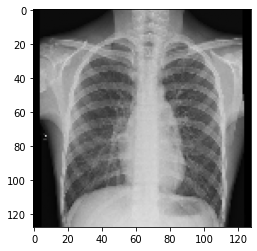

In [224]:
print("Número de imagen mostrada (ORIGINAL) --> ", num_a)

plt.imshow(test_sanas_images_totales[num_a])

smallest = np.min(test_sanas_images_totales[num_a])
biggest = np.max(test_sanas_images_totales[num_a])
print("Valor de pixel mas alto original --> ",biggest)
print("Valor de pixel mas bajo original --> ",smallest)

CELDA 41 - Representación de imagen sana reconstruida

Número de imagen mostrada (RECONSTRUCCIÓN) -->  9
Valor de pixel mas alto reconstrucción -->  0.8845709
Valor de pixel mas bajo reconstrucción -->  0.00013713517


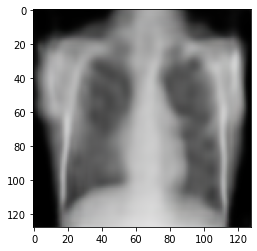

In [225]:
print("Número de imagen mostrada (RECONSTRUCCIÓN) --> ", num_a)

plt.imshow(predicted_sanas_images[num_a])

smallest = np.min(predicted_sanas_images[num_a])
biggest = np.max(predicted_sanas_images[num_a])
print("Valor de pixel mas alto reconstrucción --> ",biggest)
print("Valor de pixel mas bajo reconstrucción --> ",smallest)

CELDA 42 - Error cuadrático medio de la imagen anterior

In [226]:
mse = np.square(np.subtract(test_sanas_images_totales[num_a], predicted_sanas_images[num_a])).mean()
print("El error cuadrático medio o (MSE) obtenido al comparar la imagen original y la reconstruida es de --> ", mse)

El error cuadrático medio o (MSE) obtenido al comparar la imagen original y la reconstruida es de -->  0.004099653037133119


CELDA 43 - Similitud estructural de la imagen anterior

In [227]:
imagen_a = test_sanas_images_totales[num_a]
imagen_res = predicted_sanas_images[num_a]
ssima = ssim(imagen_a, imagen_res, multichannel=True, data_range=predicted_sanas_images[num_a].max() - predicted_sanas_images[num_a].min())
print('Structural Similarity:', ssima)

Structural Similarity: 0.6252502182725238


CELDA 44 - Presentación de varias (30) imágenes sanas originales de prueba

IMAGENES ORIGINALES
234


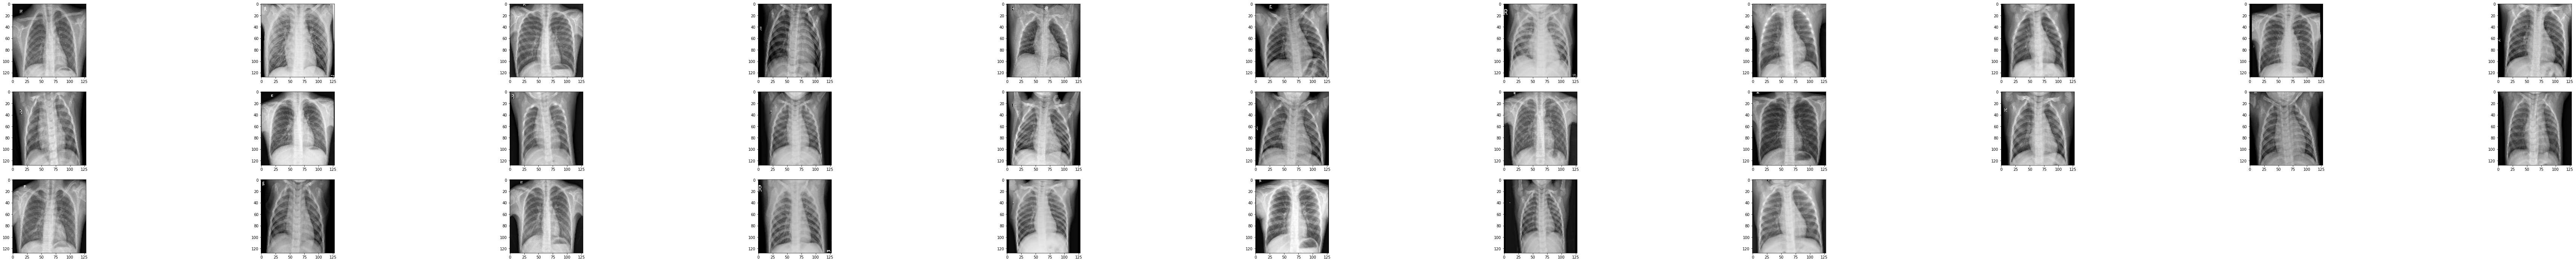

In [228]:
print("IMAGENES ORIGINALES")
plt.figure(figsize=(128, 128))
print(len(test_sanas_images_totales))
for i in range(30):
    # display original images
    ax = plt.subplot(30,11, i + 1)
    imagen = test_sanas_images_totales[i]
    plt.imshow(imagen)

CELDA 45 - Presentación de varias (30) imágenes sanas reconstruidas

IMAGENES RECONSTRUIDAS
234


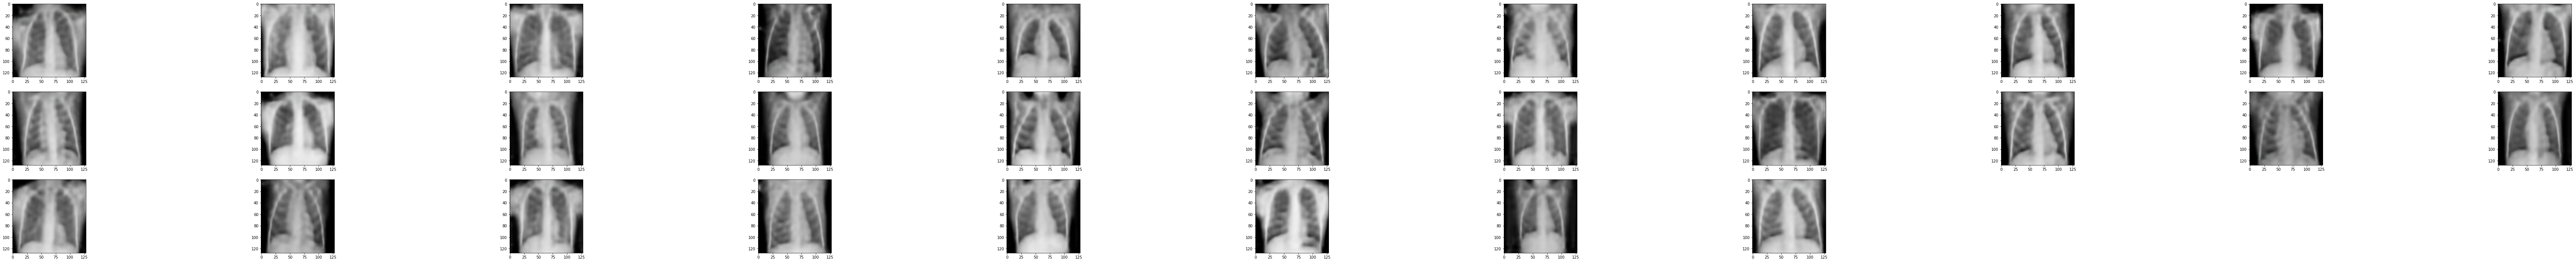

In [229]:
print("IMAGENES RECONSTRUIDAS")
plt.figure(figsize=(128, 128))
print(len(predicted_sanas_images))
for i in range(30):
    # display predicted images
    ax = plt.subplot(30,11, i + 1)
    imagen = predicted_sanas_images[i]
    plt.imshow(imagen)

CELDA 46 - Error cuadrático medio del total de imágenes sanas de prueba

In [230]:
error_e = 0
acum = 0
for i in range(len(predicted_sanas_images)):
  imagen_a = test_sanas_images_totales[i]
  imagen_b = predicted_sanas_images[i]
  error = np.square(np.subtract(imagen_a, imagen_b)).mean()
  #print(error)
  error_e = error_e + error
  #print(error_e)
  acum = acum + 1
  #print(acum)
  #print("\n")

media = error_e / acum
print("El error cuadratico medio de la reconstrucción de todas las imágenes sanas de prueba es --> ", error_e, " / ", acum, " = ", media)

El error cuadratico medio de la reconstrucción de todas las imágenes sanas de prueba es -->  0.7636983228204317  /  234  =  0.003263668046241161


CELDA 47 - Similitud estructural media del total de imágenes sanas de prueba

In [231]:
ssima_e = 0
acum = 0
for i in range(len(predicted_sanas_images)):
  imagen_a = test_sanas_images_totales[i]
  imagen_b = predicted_sanas_images[i]
  ssima = ssim(imagen_a, imagen_b, multichannel=True, data_range=predicted_sanas_images[i].max() - predicted_sanas_images[i].min())
  #print(ssima)
  ssima_e = ssima_e + ssima
  #print(ssima_e)
  acum = acum + 1
  #print(acum)
  #print("\n")

media = ssima_e / acum
print("La similitud estructural media entre las imágenes sanas de prueba originales y sus reconstrucciones es de --> ", ssima_e, " / ", acum, " = ", media)


La similitud estructural media entre las imágenes sanas de prueba originales y sus reconstrucciones es de -->  153.80165698048492  /  234  =  0.6572720383781407


# Pruebas sobre modelo autoencoder completo ENFERMAS

Vamos a calcular el MSE del modelo ENFERMAS sobre las imágenes de entrenamiento de ENFERMAS

In [232]:
predicted_enfermas_entrenamiento = autoencoder_cargado_enfermas.predict(train_enfermas_images_total)
error_e = 0
acum = 0
for i in range(len(predicted_enfermas_entrenamiento)):
  imagen_a = train_enfermas_images_total[i]
  imagen_b = predicted_enfermas_entrenamiento[i]
  error = np.square(np.subtract(imagen_a, imagen_b)).mean()
  #print(error)
  error_e = error_e + error
  #print(error_e)
  acum = acum + 1
  #print(acum)
  #print("\n")

media_enfermas_entrenamiento = error_e / acum
print("El error cuadratico medio de la reconstrucción de todas las imágenes enfermas de entrenamiento es --> ", error_e, " / ", acum, " = ", media_enfermas_entrenamiento)

43/43 [==============================] - 3s 67ms/step
El error cuadratico medio de la reconstrucción de todas las imágenes enfermas de entrenamiento es -->  2.5153646197937873  /  1360  =  0.0018495328086719025


CELD 48 - Ahora se procede a cargar las imágenes ENFERMAS de prueba y mostrar algunos valores útiles de una imagen aleatoria.

In [233]:
test_enfermas_images_1 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/test_enferma_image_file_0.npy')
test_enfermas_images_2 = np.load('/content/drive/My Drive/Colab Notebooks/TFG/test_enferma_image_file_1.npy')
test_enfermas_images_1 = np.array(test_enfermas_images_1)
test_enfermas_images_2 = np.array(test_enfermas_images_2)


print("Resumen del modelo cargado para probar")
#encoder_cargado_enfermas.summary()
#decoder_cargado_enfermas.summary()
#autoencoder_cargado_enfermas.summary

test_enfermas_images_totales = np.concatenate((test_enfermas_images_1, test_enfermas_images_2))

print("Número de imagenes enfermas de prueba --> ", len(test_enfermas_images_totales))

num_a = random.randint(0, len(test_enfermas_images_totales)-1)
print("Número de la imagen elegida -->", num_a)
test_enfermas_images_totales = test_enfermas_images_totales / 255.

smallest = np.min(test_enfermas_images_totales[num_a])
biggest = np.max(test_enfermas_images_totales[num_a])
print("Valor de pixel mas alto original --> ",biggest)
print("Valor de pixel mas bajo original --> ",smallest)


#predicted_enfermas_images = autoencoder_enfermas.predict(test_enfermas_images_totales)
predicted_enfermas_images = autoencoder_cargado_enfermas.predict(test_enfermas_images_totales)

smallest = np.min(predicted_enfermas_images[num_a])
biggest = np.max(predicted_enfermas_images[num_a])
print("Valor de pixel mas alto reconstruido --> ",biggest)
print("Valor de pixel mas bajo reconstruido --> ",smallest)

#predicted_images = predicted_images * 255

#smallest = np.min(predicted_images[num])
#biggest = np.max(predicted_images[num])
#print("Valor de pixel mas alto con preproceso --> ",biggest)
#print("Valor de pixel mas bajo con prerpoceso --> ",smallest)

#predicted_images = postprocess(predicted_images)
#print(len(predicted_images))
print("Forma de imágenes reconstruidas --> ", predicted_enfermas_images.shape)

Resumen del modelo cargado para probar
Número de imagenes enfermas de prueba -->  234
Número de la imagen elegida --> 127
Valor de pixel mas alto original -->  1.0
Valor de pixel mas bajo original -->  0.0
8/8 [==============================] - 0s 60ms/step
Valor de pixel mas alto reconstruido -->  0.81272
Valor de pixel mas bajo reconstruido -->  0.0013023751
Forma de imágenes reconstruidas -->  (234, 128, 128, 3)


CELDA 49 - Representación de imagen enferma original

Número de imagen mostrada (ORIGINAL) -->  127
Valor de pixel mas alto original -->  1.0
Valor de pixel mas bajo original -->  0.0


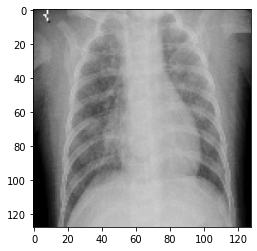

In [234]:
print("Número de imagen mostrada (ORIGINAL) --> ", num_a)

plt.imshow(test_enfermas_images_totales[num_a])

smallest = np.min(test_enfermas_images_totales[num_a])
biggest = np.max(test_enfermas_images_totales[num_a])
print("Valor de pixel mas alto original --> ",biggest)
print("Valor de pixel mas bajo original --> ",smallest)

CELDA 50 - Representación de imagen enferma reconstruida

Número de imagen mostrada (RECONSTRUCCIÓN) -->  127
Valor de pixel mas alto reconstrucción -->  0.81272
Valor de pixel mas bajo reconstrucción -->  0.0013023751


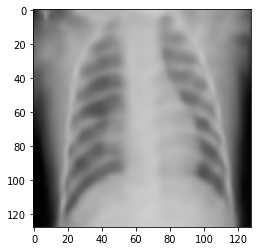

In [235]:
print("Número de imagen mostrada (RECONSTRUCCIÓN) --> ", num_a)

plt.imshow(predicted_enfermas_images[num_a])

smallest = np.min(predicted_enfermas_images[num_a])
biggest = np.max(predicted_enfermas_images[num_a])
print("Valor de pixel mas alto reconstrucción --> ",biggest)
print("Valor de pixel mas bajo reconstrucción --> ",smallest)

CELDA 51 - Error cuadrático medio de la imagen anterior

In [236]:
mse = np.square(np.subtract(test_enfermas_images_totales[num_a], predicted_enfermas_images[num_a])).mean()
print("MSE:", mse)

MSE: 0.0010519823581850217


CELDA 52 - Similitud estructural  de la imagen anterior

In [237]:
imagen_a = test_enfermas_images_totales[num_a]
imagen_a = np.array(imagen_a)

imagen_res = predicted_enfermas_images[num_a]
imagen_res = np.array(imagen_res)
ssima = ssim(imagen_a, imagen_res, multichannel=True, data_range=predicted_enfermas_images[num_a].max() - predicted_enfermas_images[num_a].min())
print('Structural Similarity:', ssima)

Structural Similarity: 0.8409290478411949


CELDA 53 - Presentación de varias (30) imágenes enfermas de prueba originales

IMAGENES ORIGINALES
234


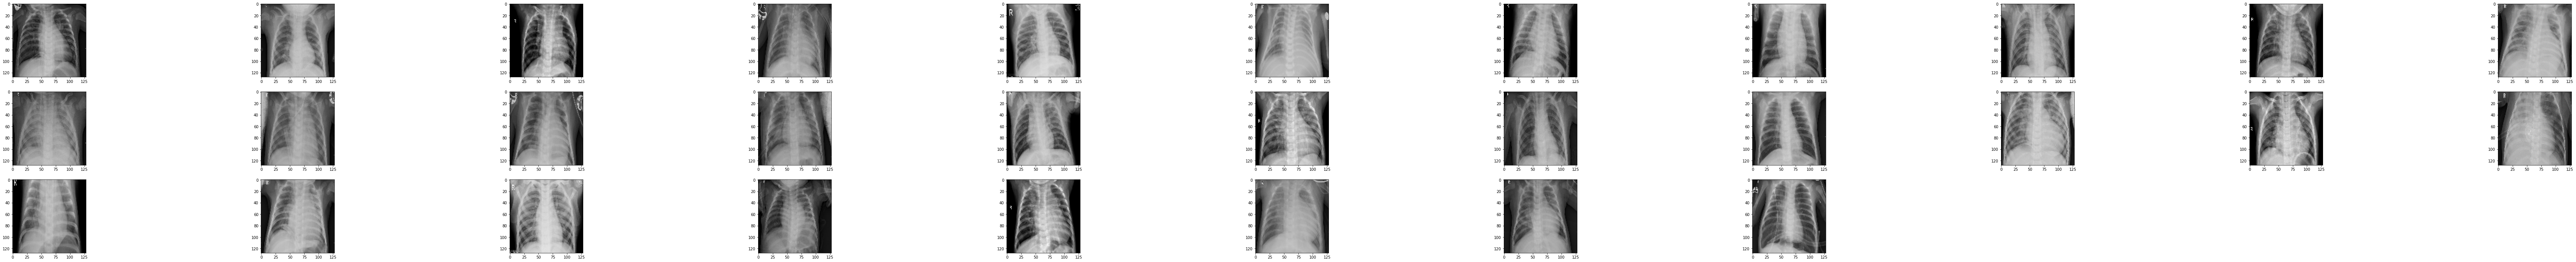

In [238]:
print("IMAGENES ORIGINALES")
plt.figure(figsize=(128, 128))
print(len(test_enfermas_images_totales))
for i in range(30):
    # display original images
    ax = plt.subplot(30,11, i + 1)
    imagen = test_enfermas_images_totales[i]
    plt.imshow(imagen)

CELDA 54 - Presentación de varias (30) imágenes enfermas reconstruidas

IMAGENES RECONSTRUIDAS
234


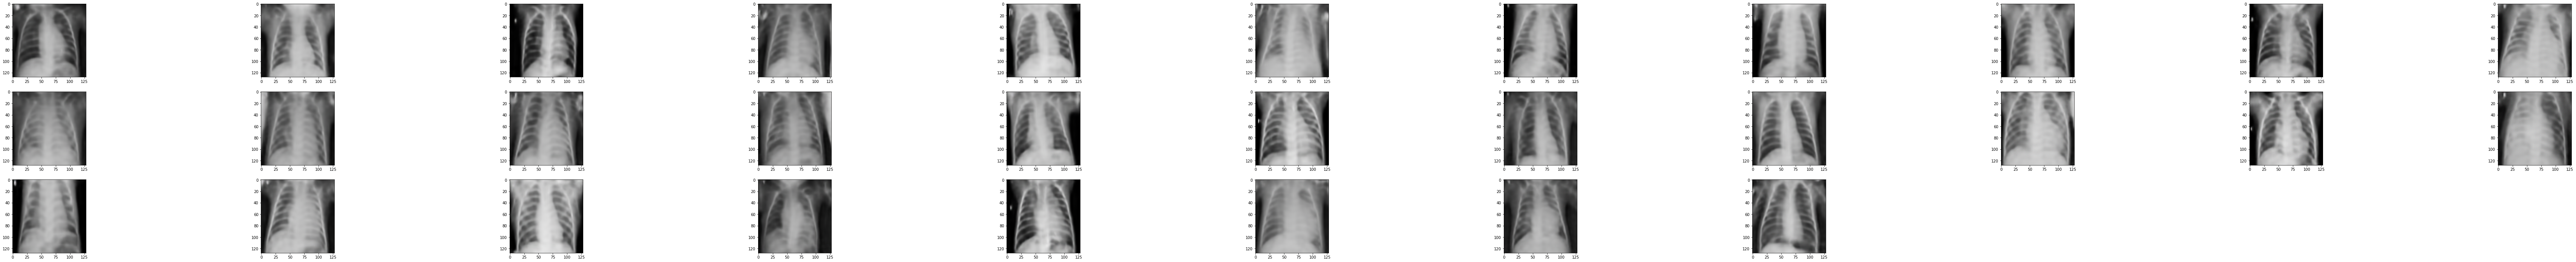

In [239]:
print("IMAGENES RECONSTRUIDAS")
plt.figure(figsize=(128, 128))
print(len(predicted_enfermas_images))
for i in range(30):
    # display predicted images
    ax = plt.subplot(30,11, i + 1)
    imagen = predicted_enfermas_images[i]
    plt.imshow(imagen)

CELDA 55 - Error cuadrático medio del total de imágenes enfermas de prueba

In [240]:
error_e = 0
acum = 0
for i in range(len(predicted_enfermas_images)):
  imagen_a = test_enfermas_images_totales[i]
  imagen_b = predicted_enfermas_images[i]
  error = np.square(np.subtract(imagen_a, imagen_b)).mean()
  #print(error)
  error_e = error_e + error
  #print(error_e)
  acum = acum + 1
  #print(acum)
  #print("\n")

media = error_e / acum
print("El error cuadratico medio de la reconstrucción de todas las imágenes enfermas de prueba es --> ", error_e, " / ", acum, " = ", media)

El error cuadratico medio de la reconstrucción de todas las imágenes enfermas de prueba es -->  0.44815991854641396  /  234  =  0.0019152133271214272


CELDA 56 - Similitud estructural medio del total de imágenes enfermas de prueba

In [241]:
ssima_e = 0
acum = 0
for i in range(len(predicted_enfermas_images)):
  imagen_a = test_enfermas_images_totales[i]
  imagen_b = predicted_enfermas_images[i]
  ssima = ssim(imagen_a, imagen_b, multichannel=True, data_range=predicted_enfermas_images[i].max() - predicted_enfermas_images[i].min())
  #print(ssima)
  ssima_e = ssima_e + ssima
  #print(ssima_e)
  acum = acum + 1
  #print(acum)
  #print("\n")

media = ssima_e / acum
print("La similitud estructural media entre las imágenes enfermas originales y sus reconstrucciones es de --> ", ssima_e, " / ", acum, " = ", media)


La similitud estructural media entre las imágenes enfermas originales y sus reconstrucciones es de -->  181.20135139558278  /  234  =  0.7743647495537725


# Carga de imágenes y etiquetas para pruebas (Sanas y Enfermas)

CELDA 57 - Carga de imágenes/etiquetas sanas y enfermas para las pruebas

In [242]:
imagenes_a = np.load('/content/drive/My Drive/Colab Notebooks/TFG/test_enferma_image_file_0.npy')
label_a = np.load('/content/drive/My Drive/Colab Notebooks/TFG/test_enferma_image_label_file_0.npy')
imagenes_b = np.load('/content/drive/My Drive/Colab Notebooks/TFG/test_enferma_image_file_1.npy')
label_b = np.load('/content/drive/My Drive/Colab Notebooks/TFG/test_enferma_image_label_file_1.npy')
imagenes_c = np.load('/content/drive/My Drive/Colab Notebooks/TFG/test_normal_image_file_0.npy')
label_c = np.load('/content/drive/My Drive/Colab Notebooks/TFG/test_normal_image_label_file_0.npy')
imagenes_d = np.load('/content/drive/My Drive/Colab Notebooks/TFG/test_normal_image_file_1.npy')
label_d = np.load('/content/drive/My Drive/Colab Notebooks/TFG/test_normal_image_label_file_1.npy')

imagenes_a = np.array(imagenes_a)
label_a = np.array(label_a)
imagenes_b = np.array(imagenes_b)
label_b = np.array(label_b)
imagenes_c = np.array(imagenes_c)
label_c = np.array(label_c)
imagenes_d = np.array(imagenes_d)
label_d = np.array(label_d)

imagenes_1 = np.concatenate((imagenes_a,imagenes_b,imagenes_c))
imagenes_1 = np.array(imagenes_1)
imagenes_2 = np.concatenate((imagenes_1, imagenes_d))
imagenes_2 = np.array(imagenes_2)
imagenes_sanas_enfermas_totales = shuffle(imagenes_2)
imagenes_sanas_enfermas_totales = imagenes_sanas_enfermas_totales / 255.0

label_1 = np.concatenate((label_a,label_b,label_c))
label_1 = np.array(label_1)
label_2 = np.concatenate((label_1, label_d))
label_2 = np.array(label_2)
label_sanas_enfermas_totales = shuffle(label_2)


num = random.randint(0,467)

print(len(imagenes_sanas_enfermas_totales))
print(len(label_sanas_enfermas_totales))

print(imagenes_sanas_enfermas_totales[num])
print(imagenes_sanas_enfermas_totales[num].shape)
print(label_sanas_enfermas_totales[num])

468
468
[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.08627451 0.08627451 0.08627451]
  [0.04313725 0.04313725 0.04313725]
  [0.03921569 0.03921569 0.03921569]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.09019608 0.09019608 0.09019608]
  [0.03137255 0.03137255 0.03137255]
  [0.01960784 0.01960784 0.01960784]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.07843137 0.07843137 0.07843137]
  [0.03137255 0.03137255 0.03137255]
  [0.00392157 0.00392157 0.00392157]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.  

# Pruebas sobre ambos modelos con imagen aletoria (Clasificación)

CELDA 58 - Presentación de la imagen real que se va a clasificar

Esta es la imagen real que vamos a reproducir con los diferentes modelos y a intentar clasificar en base a dichas reconstrucciones
Imagen  307
La imagen  307  es ENFERMA


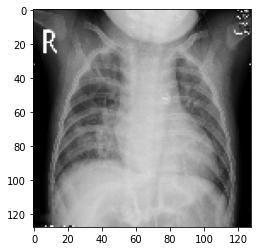

In [249]:
#a = random.randint(0, 467)
a = 307
imagen_real = imagenes_sanas_enfermas_totales[a]
label_real = label_sanas_enfermas_totales[a]
print("Esta es la imagen real que vamos a reproducir con los diferentes modelos y a intentar clasificar en base a dichas reconstrucciones")
print("Imagen ", a)
if label_real == "1":
  print("La imagen ",a," es ENFERMA")
if label_real == "0": 
  print("La imagen ",a," es SANA")
plt.imshow(imagen_real)


CELDA 59 - Presentación de imagen reconstruida con modelo de sanas

15/15 [==============================] - 1s 65ms/step
Esta imagen ha sido reconstruida con el modelo entrenado con imágenes sanas
Imagen  307
Con un error cuadrático medio de:  0.0038199589815375843
Y una similitud estructural de:  0.719526662459992


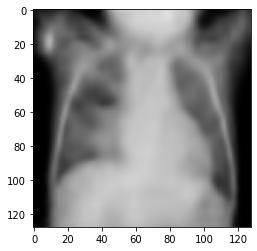

In [250]:
predicion_modelo_sana = autoencoder_cargado_sanas.predict(imagenes_sanas_enfermas_totales)

pred_sana = predicion_modelo_sana[a]

mse_sana = np.square(np.subtract(imagen_real, pred_sana)).mean()
simil_sana = ssim(pred_sana, imagen_real, multichannel=True, data_range=predicion_modelo_sana[a].max() - predicion_modelo_sana[a].min())

print("Esta imagen ha sido reconstruida con el modelo entrenado con imágenes sanas")
print("Imagen ", a)
print("Con un error cuadrático medio de: ", mse_sana)
print("Y una similitud estructural de: ", simil_sana)
plt.imshow(pred_sana)

CELDA 60 - Presentación de imagen reconstruida con modelo de enfermas

15/15 [==============================] - 1s 65ms/step
Esta imagen ha sido reconstruida con el modelo entrenado con imágenes enfermas
Imagen  307
Con un error cuadrático medio de:  0.0032455384813082013
Y una similitud estructural de:  0.7791092029626446


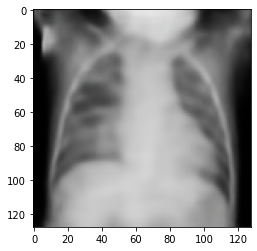

In [251]:
predicion_modelo_enferma = autoencoder_cargado_enfermas.predict(imagenes_sanas_enfermas_totales)

pred_enferma = predicion_modelo_enferma[a]

mse_enferma = np.square(np.subtract(imagen_real, pred_enferma)).mean()
simil_enferma = ssim(pred_enferma, imagen_real, multichannel=True, data_range=predicion_modelo_enferma[a].max() - predicion_modelo_enferma[a].min())

print("Esta imagen ha sido reconstruida con el modelo entrenado con imágenes enfermas")
print("Imagen ", a)
print("Con un error cuadrático medio de: ", mse_enferma)
print("Y una similitud estructural de: ", simil_enferma)
plt.imshow(pred_enferma)

CELDA 61 - Clasificación de la imagen en base a los resultados anteriormente obtenidos

In [253]:
a = str(a)
print("Similitud enferma: ", simil_enferma, "\nSimilitud sana: ", simil_sana, "\nMSE enferma: ", mse_enferma, "\nMSE sana: ", mse_sana )
if (simil_enferma > simil_sana and mse_enferma > mse_sana) : 
  print("Comparando los errores cuadráticos medios y similitud estructural de ambas reconstrucciones, podemos clasificar la imagen " + a + " como ENFERMA pero con un posible error")

if (simil_enferma > simil_sana and mse_sana > mse_enferma) : 
    print("Comparando los errores cuadráticos medios y similitud estructural de ambas reconstrucciones, podemos clasificar la imagen " + a + " como ENFERMA")

if (simil_sana > simil_enferma and mse_enferma > mse_sana) : 
    print("Comparando los errores cuadráticos medios y similitud estructural de ambas reconstrucciones, podemos clasificar la imagen " + a + " como SANA")

if (simil_sana > simil_enferma and mse_sana > mse_enferma) : 
    print("Comparando los errores cuadráticos medios y similitud estructural de ambas reconstrucciones, podemos clasificar la imagen " + a + " como SANA pero con posible error")  

if (simil_sana == simil_enferma and mse_sana > mse_enferma) : 
    print("Comparando los errores cuadráticos medios y similitud estructural de ambas reconstrucciones, no podemos clasificar la imagen " + a + " con certeza")  


Similitud enferma:  0.7791092029626446 
Similitud sana:  0.719526662459992 
MSE enferma:  0.0032455384813082013 
MSE sana:  0.0038199589815375843
Comparando los errores cuadráticos medios y similitud estructural de ambas reconstrucciones, podemos clasificar la imagen 307 como ENFERMA


CELDA 62 - Clasificador de imagen aleatoria como sana o enferma

1
Esta es la imagen real que vamos a reproducir con los diferentes modelos y a intentar clasificar en base a dichas reconstrucciones
Imagen  115
La imagen  115  es ENFERMA
15/15 [==============================] - 1s 62ms/step
MSE sana:  0.002415014034394433 
Similitud sana:  0.7169749715782737 
MSE enferma:  0.0018478297588417202 
Similitud enferma:  0.7830629279691097
Comparando los errores cuadráticos medios y similitud estructural de ambas reconstrucciones, podemos clasificar la imagen 115 como ENFERMA


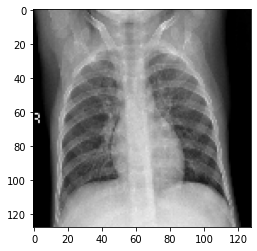

In [254]:
num = 115
#num = random.randint(0,467)

imagen_real = imagenes_sanas_enfermas_totales[num]
label_real = label_sanas_enfermas_totales[num]
print(label_real)
print("Esta es la imagen real que vamos a reproducir con los diferentes modelos y a intentar clasificar en base a dichas reconstrucciones")
print("Imagen ", num)
if label_real == "1":
  print("La imagen ",num," es ENFERMA")
if label_real == "0": 
  print("La imagen ",num," es SANA")

plt.imshow(imagen_real)

predicion_modelo_enferma = autoencoder_cargado_enfermas.predict(imagenes_sanas_enfermas_totales)
predicion_modelo_sana = autoencoder_cargado_sanas.predict(imagenes_sanas_enfermas_totales)

pred_enferma = predicion_modelo_enferma[num]
pred_sana = predicion_modelo_sana[num]

mse_enferma = np.square(np.subtract(imagen_real, pred_enferma)).mean()
simil_enferma = ssim(pred_enferma, imagen_real, multichannel=True, data_range=predicion_modelo_enferma[num].max() - predicion_modelo_enferma[num].min())

mse_sana = np.square(np.subtract(imagen_real, pred_sana)).mean()
simil_sana = ssim(pred_sana, imagen_real, multichannel=True, data_range=predicion_modelo_sana[num].max() - predicion_modelo_sana[num].min())

a = str(num)
print("MSE sana: ", mse_sana , "\nSimilitud sana: ", simil_sana, "\nMSE enferma: ", mse_enferma, "\nSimilitud enferma: ", simil_enferma)
if (simil_enferma > simil_sana and mse_enferma > mse_sana) : 
  print("Comparando los errores cuadráticos medios y similitud estructural de ambas reconstrucciones, podemos clasificar la imagen " + a + " como ENFERMA pero con un posible error")

if (simil_enferma > simil_sana and mse_sana > mse_enferma) : 
    print("Comparando los errores cuadráticos medios y similitud estructural de ambas reconstrucciones, podemos clasificar la imagen " + a + " como ENFERMA")

if (simil_sana > simil_enferma and mse_enferma > mse_sana) : 
    print("Comparando los errores cuadráticos medios y similitud estructural de ambas reconstrucciones, podemos clasificar la imagen " + a + " como SANA")

if (simil_sana > simil_enferma and mse_sana > mse_enferma) : 
    print("Comparando los errores cuadráticos medios y similitud estructural de ambas reconstrucciones, podemos clasificar la imagen " + a + " como SANA pero con posible error")  

if (simil_sana == simil_enferma and mse_sana > mse_enferma) : 
    print("Comparando los errores cuadráticos medios y similitud estructural de ambas reconstrucciones, no podemos clasificar la imagen " + a + " con certeza")  

# Pruebas sobre los modelos separados con imágenes previamente clasificadas (Sano y Enfermo)




Se elige el número del modelo a cargar

In [282]:
num_modelo_a_cargar = 5
num_modelo_a_cargar = str(num_modelo_a_cargar)

Se carga el autoencoder SANO elegido

In [283]:

path_modelo_a_cargar = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Sanos/Modelo_Autoencoder_Sanas_"+num_modelo_a_cargar+".json"
path_peso_a_cargar = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Sanos/Modelo_Autoencoder_Sanas_"+num_modelo_a_cargar+".h5"
path_encoder = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Sanos/Modelo_Encoder_Sanas_"+num_modelo_a_cargar+".json"
peso_encoder = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Sanos/Modelo_Encoder_Sanas_"+num_modelo_a_cargar+".h5"
path_decoder = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Sanos/Modelo_Decoder_Sanas_"+num_modelo_a_cargar+".json"
peso_decoder = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Sanos/Modelo_Decoder_Sanas_"+num_modelo_a_cargar+".h5"

# carga el json y crea el modelo
json_file = open(path_encoder, 'r')
loaded_model_json = json_file.read()

json_file_a = open(path_decoder, 'r')
loaded_model_json_a = json_file_a.read()

json_file_b = open(path_modelo_a_cargar, 'r')
loaded_model_json_b = json_file_b.read()

json_file.close()
json_file_a.close()
json_file_b.close()

encoder_cargado_sanas = model_from_json(loaded_model_json)
# se cargan los pesos (weights) en el nuevo modelo
encoder_cargado_sanas.load_weights(peso_encoder)
print("Modelo " + num_modelo_a_cargar+ " cargado desde el PC")
encoder_cargado_sanas.summary()

decoder_cargado_sanas = model_from_json(loaded_model_json_a)
# se cargan los pesos (weights) en el nuevo modelo
decoder_cargado_sanas.load_weights(peso_decoder)
print("Modelo " + num_modelo_a_cargar+ " cargado desde el PC")
decoder_cargado_sanas.summary()

autoencoder_cargado_sanas = model_from_json(loaded_model_json_b)
# se cargan los pesos (weights) en el nuevo modelo
autoencoder_cargado_sanas.load_weights(path_peso_a_cargar)
print("Modelo " + num_modelo_a_cargar+ " cargado desde el PC")
autoencoder_cargado_sanas.summary()

Modelo 5 cargado desde el PC
Model: "encoder_model_sanas"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 128)      0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        73792     
                  

Se carga el autoencoder ENFERMO elegido

In [284]:

path_modelo_a_cargar = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Enfermos/Modelo_Autoencoder_Enfermas_"+num_modelo_a_cargar+".json"
path_peso_a_cargar = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Enfermos/Modelo_Autoencoder_Enfermas_"+num_modelo_a_cargar+".h5"
path_encoder = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Enfermos/Modelo_Encoder_Enfermas_"+num_modelo_a_cargar+".json"
peso_encoder = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Enfermos/Modelo_Encoder_Enfermas_"+num_modelo_a_cargar+".h5"
path_decoder = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Enfermos/Modelo_Decoder_Enfermas_"+num_modelo_a_cargar+".json"
peso_decoder = "/content/drive/My Drive/Colab Notebooks/TFG/Modelos/Enfermos/Modelo_Decoder_Enfermas_"+num_modelo_a_cargar+".h5"

# carga el json y crea el modelo
json_file = open(path_encoder, 'r')
loaded_model_json = json_file.read()

json_file_a = open(path_decoder, 'r')
loaded_model_json_a = json_file_a.read()

json_file_b = open(path_modelo_a_cargar, 'r')
loaded_model_json_b = json_file_b.read()

json_file.close()
json_file_a.close()
json_file_b.close()

encoder_cargado_enfermas = model_from_json(loaded_model_json)
# se cargan los pesos (weights) en el nuevo modelo
encoder_cargado_enfermas.load_weights(peso_encoder)
print("Modelo " + num_modelo_a_cargar+ " cargado desde el PC")
encoder_cargado_enfermas.summary()

decoder_cargado_enfermas = model_from_json(loaded_model_json_a)
# se cargan los pesos (weights) en el nuevo modelo
decoder_cargado_enfermas.load_weights(peso_decoder)
print("Modelo " + num_modelo_a_cargar+ " cargado desde el PC")
decoder_cargado_enfermas.summary()

autoencoder_cargado_enfermas = model_from_json(loaded_model_json_b)
# se cargan los pesos (weights) en el nuevo modelo
autoencoder_cargado_enfermas.load_weights(path_peso_a_cargar)
print("Modelo " + num_modelo_a_cargar+ " cargado desde el PC")
autoencoder_cargado_enfermas.summary()



Modelo 5 cargado desde el PC
Model: "encoder_model_enfermas"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_24 (Conv2D)          (None, 128, 128, 128)     3584      
                                                                 
 conv2d_25 (Conv2D)          (None, 128, 128, 128)     147584    
                                                                 
 conv2d_26 (Conv2D)          (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 64, 64)        73792     
               

Según el modelo elegido, los valores de referencia cambiarán. En esta celda se asignan según el mismo.

In [290]:
print(num_modelo_a_cargar)
if num_modelo_a_cargar == "1":
  mse_referencia_sanas = 0.00012193
  mse_medio_modelo_sanas = 0.00341435

  mse_referencia_enfermas = 0.00001387
  mse_medio_modelo_enfermas = 0.00188879

if num_modelo_a_cargar == "2":
  mse_referencia_sanas = 0.00008035
  mse_medio_modelo_sanas = 0.00205325

  mse_referencia_enfermas = 0.00002871
  mse_medio_modelo_enfermas = 0.00093494

if num_modelo_a_cargar == "3":
  mse_referencia_sanas = 0.00003654
  mse_medio_modelo_sanas = 0.00050597

  mse_referencia_enfermas = 0.00000045
  mse_medio_modelo_enfermas = 0.00015105

if num_modelo_a_cargar == "4":
  mse_referencia_sanas = 0.00006231
  mse_medio_modelo_sanas = 0.00340322

  mse_referencia_enfermas = 0.00008635
  mse_medio_modelo_enfermas = 0.0024027

if num_modelo_a_cargar == "5":
  mse_referencia_sanas = 0.00002047
  mse_medio_modelo_sanas = 0.00338022

  mse_referencia_enfermas = 0.00085007
  mse_medio_modelo_enfermas = 0.00155527


print("Modelo ", num_modelo_a_cargar, " --> MSE referencia sanas:", mse_referencia_sanas,"; MSE referencia_enfermas:", mse_referencia_enfermas)

5
Modelo  5  --> MSE referencia sanas: 2.047e-05 ; MSE referencia_enfermas: 0.00085007


Se realiza el prodecimiento de clasificación basándonos en la comparación entre el MSE obtenido en la imagen de prueba a clasficar y el MSE de referencia anteriormente asignado. Se calcula el porcentaje de acierto.

Primero sobre el modelo SANO y con imágenes de prueba sanas

In [291]:
sumatorio = 0

predicion_modelo_sana = autoencoder_cargado_sanas.predict(test_sanas_images_totales)
leng = len(test_sanas_images_totales)

for i in range(len(test_sanas_images_totales)):
    
    imagen_real = test_sanas_images_totales[i]
    pred_sana = predicion_modelo_sana[i]
    mse_sana = np.square(np.subtract(imagen_real, pred_sana)).mean()
    x = abs(mse_medio_modelo_sanas - mse_sana)
    if (x < mse_referencia_sanas ) :
      print(mse_sana)
      print(mse_medio_modelo_sanas)
      print(x)
      print(mse_referencia_sanas)
      print("//")
      sumatorio = sumatorio + 1
      #print("1")
    else:
      print(mse_sana)
      print(mse_medio_modelo_sanas)
      print(x)
      print(mse_referencia_sanas)
      print("//")
      sumatorio = sumatorio + 0
  
  
leng = len(test_sanas_images_totales)
result = sumatorio / leng
result = result * 100
print("De un total de ", leng, " imágenes SANAS, nuestro modelo ", num_modelo_a_cargar," ha acertado ", sumatorio, "/",leng, "es decir, un ", result, "% de acierto")

8/8 [==============================] - 1s 137ms/step
0.003237610877173064
0.00338022
0.00014260912282693626
2.047e-05
//
0.005495268556066923
0.00338022
0.0021150485560669226
2.047e-05
//
0.005120189655164244
0.00338022
0.0017399696551642437
2.047e-05
//
0.004299140486410827
0.00338022
0.0009189204864108271
2.047e-05
//
0.0027739762309181635
0.00338022
0.0006062437690818366
2.047e-05
//
0.005225343290397416
0.00338022
0.0018451232903974155
2.047e-05
//
0.003642807866079008
0.00338022
0.0002625878660790079
2.047e-05
//
0.0024328116441451986
0.00338022
0.0009474083558548016
2.047e-05
//
0.0020768043982772647
0.00338022
0.0013034156017227355
2.047e-05
//
0.004441225265184249
0.00338022
0.0010610052651842485
2.047e-05
//
0.0030271186775831676
0.00338022
0.0003531013224168326
2.047e-05
//
0.002926865723448243
0.00338022
0.0004533542765517572
2.047e-05
//
0.003809882741250351
0.00338022
0.00042966274125035096
2.047e-05
//
0.002708690755136819
0.00338022
0.0006715292448631811
2.047e-05
//
0.0

Segundo sobre el modelo ENFERMO y utilizando imágenes enfermas de prueba

In [292]:
sumatorio = 0
predicion_modelo_enferma = autoencoder_cargado_enfermas.predict(test_enfermas_images_totales)

leng = len(test_enfermas_images_totales)

for i in range(len(test_enfermas_images_totales)):

  imagen_real = test_enfermas_images_totales[i]

  pred_enferma = predicion_modelo_enferma[i]

  mse_enferma = np.square(np.subtract(imagen_real, pred_enferma)).mean()

  x = abs(mse_medio_modelo_enfermas - mse_enferma)
  if (x > mse_referencia_enfermas ) :
    print(mse_medio_modelo_enfermas)
    print(mse_enferma)
    print(mse_referencia_enfermas)
    print("//")
    sumatorio = sumatorio + 1
    #print("1")
  else:
    print(mse_medio_modelo_enfermas)
    print(mse_enferma)
    print(x)
    print(mse_referencia_enfermas)
    print("//")
    sumatorio = sumatorio + 0
  
  
leng = len(test_enfermas_images_totales)
result = sumatorio / leng
result = result * 100
print("De un total de ", leng, " imágenes ENFERMAS, nuestro modelo ",num_modelo_a_cargar," ha acertado ", sumatorio, "/",leng, "es decir, un ", result, "% de acierto")

8/8 [==============================] - 1s 137ms/step
0.00155527
0.0021017161786763923
0.0005464461786763922
0.00085007
//
0.00155527
0.0008529788440300727
0.0007022911559699274
0.00085007
//
0.00155527
0.002286355732365843
0.0007310857323658431
0.00085007
//
0.00155527
0.002251525802422574
0.0006962558024225739
0.00085007
//
0.00155527
0.0019288545059865
0.0003735845059864998
0.00085007
//
0.00155527
0.0010468272611651802
0.0005084427388348199
0.00085007
//
0.00155527
0.0012041661429810484
0.00035110385701895164
0.00085007
//
0.00155527
0.001201938997433138
0.000353331002566862
0.00085007
//
0.00155527
0.001089771594896409
0.00046549840510359103
0.00085007
//
0.00155527
0.0016400730279377915
8.480302793779145e-05
0.00085007
//
0.00155527
0.0008928628196730988
0.0006624071803269013
0.00085007
//
0.00155527
0.0008543640701220533
0.0007009059298779468
0.00085007
//
0.00155527
0.001428340931444445
0.00012692906855555513
0.00085007
//
0.00155527
0.0021905639632849067
0.0006352939632849066
0

# Pruebas Totales


Primero obtengo el MSE (media y mediana) del autoencoder SANO con las imágenes SANAS de entrenamiento

In [ ]:
predicted_sanas_entrenamiento = autoencoder_cargado_sanas.predict(train_sanas_images_total)
error_e = 0
acum = 0
errores = np.array([])
for i in range(len(predicted_sanas_entrenamiento)):
  imagen_a = train_sanas_images_total[i]
  imagen_b = predicted_sanas_entrenamiento[i]
  error = np.square(np.subtract(imagen_a, imagen_b)).mean()
  #print(error)
  errores = np.append(errores, error)
  error_e = error_e + error
  #print(error_e)
  acum = acum + 1
  #print(acum)
  #print("\n")

mse_med_san_entr = error_e / acum
error_mediana_sanas = np.median(errores)
print(errores)
print(error_mediana_sanas)
print("El error cuadratico medio de la reconstrucción de todas las imágenes sanas de entrenamiento es --> ", error_e, " / ", acum, " = ", mse_med_san_entr)
print("La mediana de los errores cuadraticos medios de la reconstrucción de todas las imágenes sanas de entrenamiento es --> ", error_mediana_sanas)

[0.00047056 0.00069514 0.00035913 ... 0.0004679  0.00030873 0.0004381 ]
0.00048597866356985876
El error cuadratico medio de la reconstrucción de todas las imágenes sanas de entrenamiento es -->  0.6779970888516563  /  1340  =  0.0005059679767549675
La mediana de los errores cuadraticos medios de la reconstrucción de todas las imágenes sanas de entrenamiento es -->  0.00048597866356985876


Segundo obtenemos el MSE (media y mediana) del autoencoder ENNFERMO con las imágenes ENFERMAS de entrenamiento

In [ ]:
predicted_enfermas_entrenamiento = autoencoder_cargado_enfermas.predict(train_enfermas_images_total)
error_e = 0
acum = 0
errores = np.array([])
for i in range(len(predicted_enfermas_entrenamiento)):
  imagen_a = train_enfermas_images_total[i]
  imagen_b = predicted_enfermas_entrenamiento[i]
  error = np.square(np.subtract(imagen_a, imagen_b)).mean()
  #print(error)
  errores = np.append(errores, error)
  error_e = error_e + error
  #print(error_e)
  acum = acum + 1
  #print(acum)
  #print("\n")

mse_med_enf_entr = error_e / acum
error_mediana_enfermas = np.median(errores)
print(errores)
print(error_mediana_enfermas)
print("El error cuadratico medio de la reconstrucción de todas las imágenes enfermas de entrenamiento es --> ", error_e, " / ", acum, " = ", mse_med_enf_entr)
print("La mediana de los errores cuadraticos medios de la reconstrucción de todas las imágenes enfermas de entrenamiento es --> ", error_mediana_enfermas)

[1.24293083e-04 1.57198481e-04 1.40246620e-04 ... 1.74051501e-04
 1.20982519e-04 7.28102710e-05]
0.00014182422587168174
El error cuadratico medio de la reconstrucción de todas las imágenes enfermas de entrenamiento es -->  0.2054302885590988  /  1360  =  0.00015105168276404325
La mediana de los errores cuadraticos medios de la reconstrucción de todas las imágenes enfermas de entrenamiento es -->  0.00014182422587168174


Probamos la clasificación de nuestro modelo ENFERMO sobre las imágenes de prueba ENFERMAS y utilizando la MEDIA

In [ ]:
sumatorio = 0
predicion_modelo_enferma = autoencoder_cargado_enfermas.predict(test_enfermas_images_totales)
predicion_modelo_sana = autoencoder_cargado_sanas.predict(test_enfermas_images_totales)
leng = len(test_enfermas_images_totales)

for i in range(len(test_enfermas_images_totales)):

  imagen_real = test_enfermas_images_totales[i]

  pred_enferma = predicion_modelo_enferma[i]
  pred_sana = predicion_modelo_sana[i]

  mse_enferma = np.square(np.subtract(imagen_real, pred_enferma)).mean()
  mse_sana = np.square(np.subtract(imagen_real, pred_sana)).mean()
  
  x = abs(mse_med_enf_entr - mse_enferma)
  y = abs(mse_med_san_entr - mse_sana)
  
  if (y > x) :
    print("MSE_ENFERMA", x)
    print("MSE_SANA", y)
    print("Enferma")
    print("//")
    sumatorio = sumatorio + 1
    #print("1")
    
  else:
    print("MSE_ENFERMA", x)
    print("MSE_SANA", y)
    print("Sana")
    print("//")
    sumatorio = sumatorio + 0
  
  
leng = len(test_enfermas_images_totales)
result = sumatorio / leng
result = result * 100
print("De un total de ", leng, " imágenes ENFERMAS, nuestro modelo ha acertado ", sumatorio, "/",leng, "es decir, un ", result, "% de acierto")

MSE_ENFERMA 1.9858327491819157e-05
MSE_SANA 0.00017914041621378668
Enferma
//
MSE_ENFERMA 9.618556161895868e-05
MSE_SANA 0.00015089671708373752
Enferma
//
MSE_ENFERMA 2.4184214250450806e-05
MSE_SANA 0.00020832810310913958
Enferma
//
MSE_ENFERMA 6.821546273014631e-05
MSE_SANA 0.0002685364743626532
Enferma
//
MSE_ENFERMA 9.131311446620966e-06
MSE_SANA 0.00014209482995786995
Enferma
//
MSE_ENFERMA 5.59977198215937e-05
MSE_SANA 8.081843119834458e-05
Enferma
//
MSE_ENFERMA 5.1922805639806354e-05
MSE_SANA 0.00028838334000565364
Enferma
//
MSE_ENFERMA 5.260287880801758e-06
MSE_SANA 0.00013442316428374394
Enferma
//
MSE_ENFERMA 4.836558350455747e-05
MSE_SANA 0.0003131276031921624
Enferma
//
MSE_ENFERMA 3.067094395068253e-05
MSE_SANA 0.00023558836316358884
Enferma
//
MSE_ENFERMA 6.753803363250793e-05
MSE_SANA 0.0002759080705954162
Enferma
//
MSE_ENFERMA 6.021198420073217e-05
MSE_SANA 0.0002466411487042326
Enferma
//
MSE_ENFERMA 1.3157460135833268e-05
MSE_SANA 0.00022615173991394236
Enferma
//
M

Probamos la clasificación de nuestro modelo SANO sobre las imágenes de prueba SANAS y utilizando la MEDIA

In [ ]:
sumatorio = 0

predicion_modelo_enferm = autoencoder_cargado_enfermas.predict(test_sanas_images_totales)
predicion_modelo_sana = autoencoder_cargado_sanas.predict(test_sanas_images_totales)
leng = len(test_sanas_images_totales)

for i in range(len(test_sanas_images_totales)):
    
  imagen_real = test_sanas_images_totales[i]

  pred_enferma = predicion_modelo_enferm[i]
  pred_sana = predicion_modelo_sana[i]

  mse_enferma = np.square(np.subtract(imagen_real, pred_enferma)).mean()
  mse_sana = np.square(np.subtract(imagen_real, pred_sana)).mean()
    
  x = abs(mse_med_enf_entr - mse_enferma)
  y = abs(mse_med_san_entr - mse_sana)
  
  if (x > y) :
    print("MSE_ENFERMA", x)
    print("MSE_SANA", y)
    print("Sana")
    print("//")
    sumatorio = sumatorio + 1
    #print("1")
    
  else:
    print("MSE_ENFERMA", x)
    print("MSE_SANA", y)
    print("Enferma")
    print("//")
    sumatorio = sumatorio + 0
  
  
leng = len(test_sanas_images_totales)
result = sumatorio / leng
result = result * 100
print("De un total de ", leng, " imágenes SANAS, nuestro modelo ha acertado ", sumatorio, "/",leng, "es decir, un ", result, "% de acierto")

MSE_ENFERMA 4.15174045935725e-05
MSE_SANA 0.0002881778919918504
Enferma
//
MSE_ENFERMA 9.321630282175912e-06
MSE_SANA 0.00019868727488060246
Enferma
//
MSE_ENFERMA 1.9013776697636778e-05
MSE_SANA 0.00010724324522618975
Enferma
//
MSE_ENFERMA 4.656303535482181e-05
MSE_SANA 7.263758320027964e-05
Enferma
//
MSE_ENFERMA 1.1915975902811833e-05
MSE_SANA 0.00010350042800191941
Enferma
//
MSE_ENFERMA 9.205367193765028e-05
MSE_SANA 0.00010227633456741608
Enferma
//
MSE_ENFERMA 0.00012296482596524968
MSE_SANA 0.0001663909157957115
Enferma
//
MSE_ENFERMA 3.62471263548645e-05
MSE_SANA 3.0122234282054362e-05
Sana
//
MSE_ENFERMA 5.380753153904429e-06
MSE_SANA 0.00014175871632131462
Enferma
//
MSE_ENFERMA 7.897707928269183e-06
MSE_SANA 8.447618214592133e-05
Enferma
//
MSE_ENFERMA 3.395604702768323e-05
MSE_SANA 2.752708682741853e-05
Sana
//
MSE_ENFERMA 2.0654306586057562e-05
MSE_SANA 6.038318070678873e-05
Enferma
//
MSE_ENFERMA 5.551484715123607e-05
MSE_SANA 2.9454325424945014e-05
Sana
//
MSE_ENFERMA 

Probamos la clasificación de nuestro modelo ENFERMO sobre las imágenes de prueba ENFERMAS y utilizando la MEDIANA

In [ ]:
sumatorio = 0
predicion_modelo_enferma = autoencoder_cargado_enfermas.predict(test_enfermas_images_totales)
predicion_modelo_sana = autoencoder_cargado_sanas.predict(test_enfermas_images_totales)
leng = len(test_enfermas_images_totales)

for i in range(len(test_enfermas_images_totales)):

  imagen_real = test_enfermas_images_totales[i]

  pred_enferma = predicion_modelo_enferma[i]
  pred_sana = predicion_modelo_sana[i]

  mse_enferma = np.square(np.subtract(imagen_real, pred_enferma)).mean()
  mse_sana = np.square(np.subtract(imagen_real, pred_sana)).mean()
  
  x = abs(error_mediana_enfermas - mse_enferma)
  y = abs(error_mediana_sanas - mse_sana)
  
  if (y > x) :
    print("MSE_ENFERMA", x)
    print("MSE_SANA", y)
    print("Enferma")
    print("//")
    sumatorio = sumatorio + 1
    #print("1")
    
  else:
    print("MSE_ENFERMA", x)
    print("MSE_SANA", y)
    print("Sana")
    print("//")
    sumatorio = sumatorio + 0
  
  
leng = len(test_enfermas_images_totales)
result = sumatorio / leng
result = result * 100
print("De un total de ", leng, " imágenes ENFERMAS, nuestro modelo ha acertado ", sumatorio, "/",leng, "es decir, un ", result, "% de acierto")

MSE_ENFERMA 1.063087059945765e-05
MSE_SANA 0.000159151103028678
Enferma
//
MSE_ENFERMA 0.00010541301851132019
MSE_SANA 0.00017088603026884622
Enferma
//
MSE_ENFERMA 1.4956757358089299e-05
MSE_SANA 0.0001883387899240309
Enferma
//
MSE_ENFERMA 5.89880058377848e-05
MSE_SANA 0.0002485471611775445
Enferma
//
MSE_ENFERMA 9.614544574054165e-08
MSE_SANA 0.00012210551677276126
Enferma
//
MSE_ENFERMA 6.522517671395521e-05
MSE_SANA 0.00010080774438345327
Enferma
//
MSE_ENFERMA 4.2695348747444847e-05
MSE_SANA 0.00026839402682054495
Enferma
//
MSE_ENFERMA 3.96716901155975e-06
MSE_SANA 0.00011443385109863525
Enferma
//
MSE_ENFERMA 3.9138126612195965e-05
MSE_SANA 0.0002931382900070537
Enferma
//
MSE_ENFERMA 2.144348705832102e-05
MSE_SANA 0.00021559904997848014
Enferma
//
MSE_ENFERMA 5.831057674014642e-05
MSE_SANA 0.0002559187574103075
Enferma
//
MSE_ENFERMA 5.098452730837066e-05
MSE_SANA 0.0002266518355191239
Enferma
//
MSE_ENFERMA 3.93000324347176e-06
MSE_SANA 0.00024614105309905105
Enferma
//
MSE_E

Probamos la clasificación de nuestro modelo SANO sobre las imágenes de prueba SANAS y utilizando la MEDIANA

In [ ]:
sumatorio = 0

predicion_modelo_enferm = autoencoder_cargado_enfermas.predict(test_sanas_images_totales)
predicion_modelo_sana = autoencoder_cargado_sanas.predict(test_sanas_images_totales)
leng = len(test_sanas_images_totales)

for i in range(len(test_sanas_images_totales)):
    
  imagen_real = test_sanas_images_totales[i]

  pred_enferma = predicion_modelo_enferm[i]
  pred_sana = predicion_modelo_sana[i]

  mse_enferma = np.square(np.subtract(imagen_real, pred_enferma)).mean()
  mse_sana = np.square(np.subtract(imagen_real, pred_sana)).mean()
    
#  x = abs(mse_med_enf_entr - mse_enferma)
#  y = abs(mse_med_san_entr - mse_sana)

  x = abs(error_mediana_enfermas - mse_enferma)
  y = abs(error_mediana_sanas - mse_sana)
  
  if (x > y) :
    print("MSE_ENFERMA", x)
    print("MSE_SANA", y)
    print("Sana")
    print("//")
    sumatorio = sumatorio + 1
    #print("1")
    
  else:
    print("MSE_ENFERMA", x)
    print("MSE_SANA", y)
    print("Enferma")
    print("//")
    sumatorio = sumatorio + 0
  
  
leng = len(test_sanas_images_totales)
result = sumatorio / leng
result = result * 100
print("De un total de ", leng, " imágenes SANAS, nuestro modelo ha acertado ", sumatorio, "/",leng, "es decir, un ", result, "% de acierto")

MSE_ENFERMA 3.228994770121099e-05
MSE_SANA 0.0002681885788067417
Enferma
//
MSE_ENFERMA 9.417338981440419e-08
MSE_SANA 0.00017869796169549376
Enferma
//
MSE_ENFERMA 2.8241233589998286e-05
MSE_SANA 8.725393204108106e-05
Enferma
//
MSE_ENFERMA 5.5790492247183315e-05
MSE_SANA 5.264827001517095e-05
Sana
//
MSE_ENFERMA 2.114343279517334e-05
MSE_SANA 8.351111481681072e-05
Enferma
//
MSE_ENFERMA 0.00010128112883001178
MSE_SANA 0.00012226564775252478
Enferma
//
MSE_ENFERMA 0.0001321922828576112
MSE_SANA 0.0001863802289808202
Enferma
//
MSE_ENFERMA 4.547458324722601e-05
MSE_SANA 1.0132921096945669e-05
Sana
//
MSE_ENFERMA 3.846703738457079e-06
MSE_SANA 0.00012176940313620593
Enferma
//
MSE_ENFERMA 1.712516482063069e-05
MSE_SANA 6.448686896081264e-05
Enferma
//
MSE_ENFERMA 4.318350392004474e-05
MSE_SANA 7.5377736423098344e-06
Sana
//
MSE_ENFERMA 2.988176347841907e-05
MSE_SANA 4.039386752168004e-05
Enferma
//
MSE_ENFERMA 6.474230404359757e-05
MSE_SANA 9.46501223983632e-06
Sana
//
MSE_ENFERMA 2.932

AHORA PROBAMOS CON LA SIMILITUD

In [ ]:
predicted_sanas_entrenamiento = autoencoder_cargado_sanas.predict(train_sanas_images_total)
ssima_e = 0
acum = 0
similitudes = np.array([])
for i in range(len(predicted_sanas_entrenamiento)):
  imagen_a = train_sanas_images_total[i]
  imagen_b = predicted_sanas_entrenamiento[i]
  ssima = ssim(imagen_a, imagen_b, multichannel=True, data_range=predicted_sanas_entrenamiento[i].max() - predicted_sanas_entrenamiento[i].min())
  ssima_e = ssima_e + ssima
  similitudes = np.append(similitudes, ssima)
  acum = acum + 1
  
sim_med_san_ent = ssima_e / acum
similitudes_mediana_sanas = np.median(similitudes)
print(similitudes)
print(similitudes_mediana_sanas)
print("La similitud media de la reconstrucción de todas las imágenes sanas de entrenamiento es --> ", ssima_e, " / ", acum, " = ", sim_med_san_ent)
print("La similitud mediana de la reconstrucción de todas las imágenes sanas de entrenamiento es --> ", similitudes_mediana_sanas)

[0.96031399 0.95785805 0.95952683 ... 0.95696326 0.96534776 0.96201896]
0.9560483477569243
La similitud media de la reconstrucción de todas las imágenes sanas de entrenamiento es -->  1279.5856978408046  /  1340  =  0.9549146998811975
La similitud mediana de la reconstrucción de todas las imágenes sanas de entrenamiento es -->  0.9560483477569243


In [ ]:
predicted_enfermas_entrenamiento = autoencoder_cargado_enfermas.predict(train_enfermas_images_total)
ssima_e = 0
acum = 0
similitudes = np.array([])
for i in range(len(predicted_enfermas_entrenamiento)):
  imagen_a = train_enfermas_images_total[i]
  imagen_b = predicted_enfermas_entrenamiento[i]
  ssima = ssim(imagen_a, imagen_b, multichannel=True, data_range=predicted_enfermas_entrenamiento[i].max() - predicted_enfermas_entrenamiento[i].min())
  ssima_e = ssima_e + ssima
  similitudes = np.append(similitudes, ssima)
  acum = acum + 1
  
sim_med_enf_ent = ssima_e / acum
similitudes_mediana_enfermas = np.median(similitudes)
print(similitudes)
print(similitudes_mediana_enfermas)
print("La similitud media de la reconstrucción de todas las imágenes enfermas de entrenamiento es --> ", ssima_e, " / ", acum, " = ", sim_med_enf_ent)
print("La similitud mediana de la reconstrucción de todas las imágenes enfermas de entrenamiento es --> ", similitudes_mediana_enfermas)

[0.98537419 0.98172256 0.98523381 ... 0.98587766 0.98510188 0.99067716]
0.9844197476911922
La similitud media de la reconstrucción de todas las imágenes enfermas de entrenamiento es -->  1337.8856995906306  /  1360  =  0.9837394849931107
La similitud mediana de la reconstrucción de todas las imágenes enfermas de entrenamiento es -->  0.9844197476911922


Probamos la clasificación de nuestro modelo ENFERMO sobre las imágenes de prueba ENFERMAS y utilizando la MEDIA

In [ ]:
sumatorio = 0
predicion_modelo_enferma = autoencoder_cargado_enfermas.predict(test_enfermas_images_totales)
predicion_modelo_sana = autoencoder_cargado_sanas.predict(test_enfermas_images_totales)
leng = len(test_enfermas_images_totales)

for i in range(len(test_enfermas_images_totales)):

  imagen_real = test_enfermas_images_totales[i]

  pred_enferma = predicion_modelo_enferma[i]
  pred_sana = predicion_modelo_sana[i]

  ssima_enferma = ssim(imagen_real, pred_enferma, multichannel=True, data_range=predicion_modelo_enferma[i].max() - predicion_modelo_enferma[i].min())
  ssima_sana = ssim(imagen_real, pred_enferma, multichannel=True, data_range=predicion_modelo_sana[i].max() - predicion_modelo_sana[i].min())

  x = abs(sim_med_enf_ent - ssima_enferma)
  y = abs(sim_med_san_ent - ssima_sana)
  
  if (y > x) :
    print("SIMILITUD_ENFERMA", x)
    print("SIMILITUD_SANA", y)
    print("Enferma")
    print("//")
    sumatorio = sumatorio + 1
    #print("1")
    
  else:
    print("SIMILITUD_ENFERMA", x)
    print("SIMILITUD_SANA", y)
    print("Sana")
    print("//")
    sumatorio = sumatorio + 0
  
  
leng = len(test_enfermas_images_totales)
result = sumatorio / leng
result = result * 100
print("De un total de ", leng, " imágenes ENFERMAS, nuestro modelo ha acertado ", sumatorio, "/",leng, "es decir, un ", result, "% de acierto")

SIMILITUD_ENFERMA 0.004711457319264478
SIMILITUD_SANA 0.03325451007841285
Enferma
//
SIMILITUD_ENFERMA 0.0019234604149592771
SIMILITUD_SANA 0.030765978136007344
Enferma
//
SIMILITUD_ENFERMA 0.006429051465035918
SIMILITUD_SANA 0.03506186490560481
Enferma
//
SIMILITUD_ENFERMA 0.006370299451566086
SIMILITUD_SANA 0.03507126483930889
Enferma
//
SIMILITUD_ENFERMA 0.002254539937161071
SIMILITUD_SANA 0.03133402400456842
Enferma
//
SIMILITUD_ENFERMA 0.000632297151028971
SIMILITUD_SANA 0.028840014050144802
Enferma
//
SIMILITUD_ENFERMA 0.003941086734481458
SIMILITUD_SANA 0.0327042918150795
Enferma
//
SIMILITUD_ENFERMA 0.0005536200205694675
SIMILITUD_SANA 0.029483749417718808
Enferma
//
SIMILITUD_ENFERMA 0.003435840823386771
SIMILITUD_SANA 0.03154965376395635
Enferma
//
SIMILITUD_ENFERMA 0.0013594645745838019
SIMILITUD_SANA 0.028835433626285822
Enferma
//
SIMILITUD_ENFERMA 0.0046802914677080976
SIMILITUD_SANA 0.03345909182722184
Enferma
//
SIMILITUD_ENFERMA 0.005965368021687345
SIMILITUD_SANA 0.03

Probamos la clasificación de nuestro modelo SANO sobre las imágenes de prueba SANAS y utilizando la MEDIA

In [ ]:
sumatorio = 0
predicion_modelo_enferma = autoencoder_cargado_enfermas.predict(test_sanas_images_totales)
predicion_modelo_sana = autoencoder_cargado_sanas.predict(test_sanas_images_totales)
leng = len(test_sanas_images_totales)

for i in range(len(test_sanas_images_totales)):

  imagen_real = test_sanas_images_totales[i]

  pred_enferma = predicion_modelo_enferma[i]
  pred_sana = predicion_modelo_sana[i]

  ssima_enferma = ssim(imagen_real, pred_enferma, multichannel=True, data_range=predicion_modelo_enferma[i].max() - predicion_modelo_enferma[i].min())
  ssima_sana = ssim(imagen_real, pred_enferma, multichannel=True, data_range=predicion_modelo_sana[i].max() - predicion_modelo_sana[i].min())

  x = abs(sim_med_enf_ent - ssima_enferma)
  y = abs(sim_med_san_ent - ssima_sana)
  
  if (x > y) :
    print("SIMILITUD_ENFERMA", x)
    print("SIMILITUD_SANA", y)
    print("Sana")
    print("//")
    sumatorio = sumatorio + 1
    #print("1")
    
  else:
    print("SIMILITUD_ENFERMA", x)
    print("SIMILITUD_SANA", y)
    print("Enferma")
    print("//")
    sumatorio = sumatorio + 0
  
  
leng = len(test_sanas_images_totales)
result = sumatorio / leng
result = result * 100
print("De un total de ", leng, " imágenes SANAS, nuestro modelo ha acertado ", sumatorio, "/",leng, "es decir, un ", result, "% de acierto")

SIMILITUD_ENFERMA 0.0012827772291309492
SIMILITUD_SANA 0.02755513839198731
Enferma
//
SIMILITUD_ENFERMA 0.0019679635929554795
SIMILITUD_SANA 0.030762832109555105
Enferma
//
SIMILITUD_ENFERMA 0.0014258014977579503
SIMILITUD_SANA 0.027041183150729897
Enferma
//
SIMILITUD_ENFERMA 0.009692989028557752
SIMILITUD_SANA 0.018919221543682307
Enferma
//
SIMILITUD_ENFERMA 0.0009011267816204649
SIMILITUD_SANA 0.029733396176382154
Enferma
//
SIMILITUD_ENFERMA 0.0027298340513007835
SIMILITUD_SANA 0.026017551712938736
Enferma
//
SIMILITUD_ENFERMA 0.004382199020038002
SIMILITUD_SANA 0.024429759608745716
Enferma
//
SIMILITUD_ENFERMA 0.006971042806126815
SIMILITUD_SANA 0.02182156586928885
Enferma
//
SIMILITUD_ENFERMA 0.0046155603844557636
SIMILITUD_SANA 0.02409777087158682
Enferma
//
SIMILITUD_ENFERMA 0.0014667332373242692
SIMILITUD_SANA 0.030300276080743704
Enferma
//
SIMILITUD_ENFERMA 0.0011882872082255025
SIMILITUD_SANA 0.027374575787685873
Enferma
//
SIMILITUD_ENFERMA 0.0021004511117043156
SIMILITUD

Probamos la clasificación de nuestro modelo ENFERMO sobre las imágenes de prueba ENFERMAS y utilizando la MEDIANA

In [ ]:
sumatorio = 0
predicion_modelo_enferma = autoencoder_cargado_enfermas.predict(test_enfermas_images_totales)
predicion_modelo_sana = autoencoder_cargado_sanas.predict(test_enfermas_images_totales)
leng = len(test_enfermas_images_totales)

for i in range(len(test_enfermas_images_totales)):

  imagen_real = test_enfermas_images_totales[i]

  pred_enferma = predicion_modelo_enferma[i]
  pred_sana = predicion_modelo_sana[i]

  ssima_enferma = ssim(imagen_real, pred_enferma, multichannel=True, data_range=predicion_modelo_enferma[i].max() - predicion_modelo_enferma[i].min())
  ssima_sana = ssim(imagen_real, pred_enferma, multichannel=True, data_range=predicion_modelo_sana[i].max() - predicion_modelo_sana[i].min())

  x = abs(similitudes_mediana_enfermas - ssima_enferma)
  y = abs(similitudes_mediana_sanas - ssima_sana)
  
  if (y > x) :
    print("SIMILITUD_ENFERMA", x)
    print("SIMILITUD_SANA", y)
    print("Enferma")
    print("//")
    sumatorio = sumatorio + 1
    #print("1")
    
  else:
    print("SIMILITUD_ENFERMA", x)
    print("SIMILITUD_SANA", y)
    print("Sana")
    print("//")
    sumatorio = sumatorio + 0
  
  
leng = len(test_enfermas_images_totales)
result = sumatorio / leng
result = result * 100
print("De un total de ", leng, " imágenes ENFERMAS, nuestro modelo ha acertado ", sumatorio, "/",leng, "es decir, un ", result, "% de acierto")

SIMILITUD_ENFERMA 0.004031194621182954
SIMILITUD_SANA 0.03212086220268606
Enferma
//
SIMILITUD_ENFERMA 0.001243197716877753
SIMILITUD_SANA 0.02963233026028056
Enferma
//
SIMILITUD_ENFERMA 0.0057487887669543936
SIMILITUD_SANA 0.03392821702987803
Enferma
//
SIMILITUD_ENFERMA 0.005690036753484562
SIMILITUD_SANA 0.03393761696358211
Enferma
//
SIMILITUD_ENFERMA 0.0015742772390795468
SIMILITUD_SANA 0.030200376128841633
Enferma
//
SIMILITUD_ENFERMA 4.796554705255307e-05
SIMILITUD_SANA 0.027706366174418018
Enferma
//
SIMILITUD_ENFERMA 0.003260824036399934
SIMILITUD_SANA 0.031570643939352716
Enferma
//
SIMILITUD_ENFERMA 0.0001266426775120566
SIMILITUD_SANA 0.028350101541992023
Enferma
//
SIMILITUD_ENFERMA 0.002755578125305247
SIMILITUD_SANA 0.03041600588822957
Enferma
//
SIMILITUD_ENFERMA 0.0006792018765022778
SIMILITUD_SANA 0.027701785750559038
Enferma
//
SIMILITUD_ENFERMA 0.0040000287696265735
SIMILITUD_SANA 0.03232544395149506
Enferma
//
SIMILITUD_ENFERMA 0.005285105323605821
SIMILITUD_SANA 

Probamos la clasificación de nuestro modelo SANO sobre las imágenes de prueba SANAS y utilizando la MEDIANA

In [ ]:
sumatorio = 0
predicion_modelo_enferma = autoencoder_cargado_enfermas.predict(test_sanas_images_totales)
predicion_modelo_sana = autoencoder_cargado_sanas.predict(test_sanas_images_totales)
leng = len(test_sanas_images_totales)

for i in range(len(test_sanas_images_totales)):

  imagen_real = test_sanas_images_totales[i]

  pred_enferma = predicion_modelo_enferma[i]
  pred_sana = predicion_modelo_sana[i]

  ssima_enferma = ssim(imagen_real, pred_enferma, multichannel=True, data_range=predicion_modelo_enferma[i].max() - predicion_modelo_enferma[i].min())
  ssima_sana = ssim(imagen_real, pred_enferma, multichannel=True, data_range=predicion_modelo_sana[i].max() - predicion_modelo_sana[i].min())

  x = abs(similitudes_mediana_enfermas - ssima_enferma)
  y = abs(similitudes_mediana_sanas - ssima_sana)
  
  if (x > y) :
    print("SIMILITUD_ENFERMA", x)
    print("SIMILITUD_SANA", y)
    print("Sana")
    print("//")
    sumatorio = sumatorio + 1
    #print("1")
    
  else:
    print("SIMILITUD_ENFERMA", x)
    print("SIMILITUD_SANA", y)
    print("Enferma")
    print("//")
    sumatorio = sumatorio + 0
  
  
leng = len(test_sanas_images_totales)
result = sumatorio / leng
result = result * 100
print("De un total de ", leng, " imágenes SANAS, nuestro modelo ha acertado ", sumatorio, "/",leng, "es decir, un ", result, "% de acierto")

SIMILITUD_ENFERMA 0.0019630399272124732
SIMILITUD_SANA 0.026421490516260526
Enferma
//
SIMILITUD_ENFERMA 0.0012877008948739554
SIMILITUD_SANA 0.02962918423382832
Enferma
//
SIMILITUD_ENFERMA 0.0021060641958394744
SIMILITUD_SANA 0.025907535275003113
Enferma
//
SIMILITUD_ENFERMA 0.010373251726639277
SIMILITUD_SANA 0.017785573667955523
Enferma
//
SIMILITUD_ENFERMA 0.00022086408353894083
SIMILITUD_SANA 0.02859974830065537
Enferma
//
SIMILITUD_ENFERMA 0.0034100967493823076
SIMILITUD_SANA 0.02488390383721195
Enferma
//
SIMILITUD_ENFERMA 0.005062461718119526
SIMILITUD_SANA 0.02329611173301893
Enferma
//
SIMILITUD_ENFERMA 0.007651305504208339
SIMILITUD_SANA 0.020687917993562066
Enferma
//
SIMILITUD_ENFERMA 0.005295823082537288
SIMILITUD_SANA 0.022964122995860037
Enferma
//
SIMILITUD_ENFERMA 0.0007864705392427451
SIMILITUD_SANA 0.02916662820501692
Enferma
//
SIMILITUD_ENFERMA 0.0018685499063070266
SIMILITUD_SANA 0.02624092791195909
Enferma
//
SIMILITUD_ENFERMA 0.0014201884136227916
SIMILITUD_SA